HTML will be based off Jupyter Lab (Windows) generated packages

# Installing Required packages


In [1]:
# !pip install requests_cache

In [2]:
# !pip install PyPortfolioOpt

In [3]:
# !pip install yfinance

# Import packages 

In [4]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import objective_functions
from pypfopt.risk_models import CovarianceShrinkage
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import requests_cache
from math import sqrt, exp
from scipy.stats import norm
from scipy.stats import binom
from copy import deepcopy
import yfinance as yf
pd.set_option('display.max_columns', None)
np.random.seed(12345)





# Setup

## Top 30 tickers 

In [5]:
tickers = ['AAPL','AMZN','GOOG','PAYC','FB','MU','RNG','QCOM','HUBS','TSM','LRCX','MSFT','AMD','NXPI','GOOGL','PANW','FLEX','NVDA','GPN','TER','TSLA','SPLK','FISV','MNDT','VRNS','STM','SWKS','FIS','CYBR','VEEV','Risk Free']

## Best Portfolio Weightage

In [6]:
portfolio_dict_best_portfolio = {'AAPL': 0.12430984411130565,
 'AMZN': 0.09871172842058977,
 'GOOG': 0.07395014036116482,
 'PAYC': 0.07026934219592347,
 'FB': 0.04500585032231742,
 'MU': 0.043834698873916486,
 'RNG': 0.042496235516960724,
 'QCOM': 0.04099046025144996,
 'HUBS': 0.03730969399769216,
 'TSM': 0.030951985074281135,
 'LRCX': 0.02476158805942477,
 'MSFT': 0.023590436611023842,
 'AMD': 0.019575030584414514,
 'NXPI': 0.01924042272304655,
 'GOOGL': 0.01873850295312358,
 'STM': 0.02760581870402062,
 'PANW': 0.016061568261341017,
 'FLEX': 0.015559648491418035,
 'NVDA': 0.015559648491418035,
 'GPN': 0.015057720743624135,
 'TER': 0.014723104904385168,
 'TSLA': 0.013217337616745303,
 'SPLK': 0.012882721777506337,
 'FISV': 0.011544250442679588,
 'MNDT': 0.01037309899427869,
 'VRNS': 0.010038483155039723,
 'SWKS': 0.008700019798083875,
 'FIS': 0.008365403958844924,
 'CYBR': 0.007863476211051025,
 'VEEV': 0.007696168291431543,
 'MRVL': 0.007696168291431543,
 'V': 0.0063577049344756935,
 'IPGP': 0.005521165336378295,
 'ZG': 0.0053538574167588115,
 'EXPE': 0.005019241577519862,
 'NFLX': 0.004684625738280895,
 'BKNG': 0.004684625738280895,
 'NTES': 0.004517317818661412,
 'ZEN': 0.004182701979422462,
 'ADSK': 0.004015392065335246,
 'JD': 0.0038480841457157627,
 'MA': 0.0038480841457157627,
 'APH': 0.003513468306476813,
 'WDAY': 0.00334616038685733,
 'CGNX': 0.0031788524672378467,
 'STX': 0.0026769287083793975,
 'FFIV': 0.002509620788759931,
 'NLOK': 0.002509620788759931,
 'ON': 0.0018403881130481315,
 'TTWO': 0.0018403881130481315,
 'ANET': 0.0018403881130481315,
 'NOW': 0.0016730801934286665,
 'ZNGA': 0.0016730801934286665,
 'EQIX': 0.0013384643541897053,
 'BABA': 0.0013384643541897053,
 'HPQ': 0.001003848016333814,
 'YNDX': 0.001003848016333814}

## Worst Portfolio Weightage

In [7]:
portfolio_dict_worst_portfolio = {'AAPL': 0.056460346078391295,
 'AEIS': 0.03595126744441367,
 'AMBA': 0.04270720491469772,
 'COHU': 0.04765351915319589,
 'CRM': 0.03522739974321314,
 'CRUS': 0.03619255667814729,
 'CTSH': 0.01664856594728029,
 'CTXS': 0.03462419966948712,
 'DIOD': 0.038364090749925445,
 'FB': 0.031849442513375015,
 'FFIV': 0.028592106889795903,
 'FTNT': 0.03486548890322062,
 'ILMN': 0.03619255667814729,
 'JKHY': 0.027747617582336376,
 'KLAC': 0.041500781756637864,
 'KLIC': 0.03341777651142727,
 'LRCX': 0.04282784953156441,
 'NXGN': 0.03402099959576109,
 'PANW': 0.038364090749925445,
 'PCTY': 0.03136686404590801,
 'PRFT': 0.0314875086627747,
 'QCOM': 0.03486548890322062,
 'SAIC': 0.021353602457348797,
 'SIMO': 0.021353602457348797,
 'SNX': 0.006876582087150722,
 'TCEHY': 0.04898056391751464,
 'TSLA': 0.05404754578348731,
 'UI': 0.03607191206128048,
 'VRNT': 0.020388468533022574}

# Portfolio Optimisation Class

In [8]:
class PortfolioOptimizer:
    def __init__(self, risk_free_rate, start_date, end_date, risk_aversion,tickers):
        self.risk_free_rate = risk_free_rate
        self.start_date = start_date
        self.end_date = end_date
        self.risk_aversion = risk_aversion
        self.tickers = tickers
        self.returns_df = PortfolioOptimizer.get_data_for_multiple_stocks(tickers, start_date = start_date, end_date = end_date)
        self.returns_df = self.returns_df.iloc[1:] 
        self.simple_returns = np.exp(self.returns_df) -1

    def get_optimal_portfolio(self, expected_returns_function = expected_returns.mean_historical_return, cov_func = risk_models.sample_cov, upper_weight_bound = 0.25, 
                            gamma = None, constraint_mapper = None, constraint_lower = None, constraint_upper = None,  plot_weights_bool = True, plot_graph_bool = True, cal_mu = None, cal_S=None):
        # Estimating the return and var-covariance matrix
        if (cal_mu is not None): 
            mu = cal_mu 
        else:
            mu = expected_returns_function(self.simple_returns, returns_data=True)     
        if (cal_S is not None): 
            S = cal_S
        else:
            S = cov_func(self.simple_returns, returns_data=True) 

        if plot_weights_bool:
            fig_return, ax_return = plt.subplots(figsize=(10,6))
            ax_return.barh(mu.index, mu)
            ax_return.set_title("Returns Input to pypfopt")
            plotting.plot_covariance(S)
            
        # Intialising Efficient Frontier class
        ef = EfficientFrontier(mu, S,weight_bounds=(0, upper_weight_bound))
        if plot_graph_bool:
            fig, ax = plt.subplots()
            fig.set_size_inches(8.5, 5.5)
            plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False, ef_param= 'return')
        
        # add constraint 
        if (constraint_mapper != None and constraint_lower != None and constraint_upper != None):
            for i in range(0, len(constraint_mapper)):
                ef.add_sector_constraints(constraint_mapper[i], constraint_lower[i], constraint_upper[i])
        
        if (gamma != None):
            ef.add_objective(objective_functions.L2_reg, gamma=gamma) # Adding penalty for negligible weights in the final portfolio
        
        # Using Mean-Variance Optimization to optimise portfolio
        optimal_weights_portfolio_max_utility = ef.max_quadratic_utility(risk_aversion=self.risk_aversion)

        # Output portfolio performance
        ef.portfolio_performance(verbose=True, risk_free_rate=self.risk_free_rate) # return, vol, sharpe
        
        if plot_graph_bool:
            self.efficient_frontier_graph(mu, S, upper_weight_bound, ef, ax)
        
        if plot_weights_bool:
            fig2, ax2=plt.subplots()
            _weight = ef.clean_weights()
            '''
            #uncomment this part to show plot for weight >= 0 
            for stock, weight in ef.clean_weights().items():
              if weight == 0:
                del _weight[stock]
            '''
            
            ax2 = plotting.plot_weights(_weight, ax = ax2)
            fig2.set_size_inches(8.5, 5.5)

        return ef
    
    def efficient_frontier_graph(self, mu, S, upper_weight_bound, ef, ax, target_return = 0.082, target_volatility = 0.55):
        # Plot Chosen Portfolio
        ret_tangent, std_tangent, _ = ef.portfolio_performance( risk_free_rate=self.risk_free_rate)
        ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="g", label="Max Utility")

        # Find the tangency portfolio
        ef_sharpe = EfficientFrontier(mu, S,weight_bounds=(0, upper_weight_bound))
        ef_sharpe.max_sharpe(risk_free_rate=self.risk_free_rate)
        ret_tangent, std_tangent, _ = ef_sharpe.portfolio_performance(risk_free_rate=self.risk_free_rate)
        ax.scatter(std_tangent, ret_tangent, marker="D", s=100, c="r", label="Max Sharpe")

        # Find the min volatility portfolio
        try:
            ef_minvol = EfficientFrontier(mu, S,weight_bounds=(0, upper_weight_bound))
            ef_minvol.min_volatility()
            ret_tangent, std_tangent, _ = ef_minvol.portfolio_performance(risk_free_rate=self.risk_free_rate)
            ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="b", label="Min Volatility")
        except:
            pass

        # Find the efficient_risk portfolio
        try:
            ef_efficient_risk = EfficientFrontier(mu, S,weight_bounds=(0, upper_weight_bound))
            ef_efficient_risk.efficient_risk(target_volatility=target_volatility)
            ret_tangent, std_tangent, _ = ef_efficient_risk.portfolio_performance(risk_free_rate=self.risk_free_rate)
            ax.scatter(std_tangent, ret_tangent, marker="1", s=100, c="p", label=f"Efficient Risk Vol = {target_volatility:.2f}")
        except:
            pass

        # Find the efficient_return portfolio
        try:
            ef_efficient_return = EfficientFrontier(mu, S,weight_bounds=(0, upper_weight_bound))
            ef_efficient_return.efficient_return(target_return=target_return)
            ret_tangent, std_tangent, _ = ef_efficient_return.portfolio_performance(risk_free_rate=self.risk_free_rate)
            ax.scatter(std_tangent, ret_tangent, marker="^", s=100, c="y", label=f"Efficient Return  at {target_return* 100:.2f}%")
        except:
            pass

        # Generate random portfolios
        n_samples = 10000
        w = np.random.dirichlet(np.ones(len(mu)), n_samples)
        rets = w.dot(mu)
        stds = np.sqrt(np.diag(w @ S @ w.T))
        sharpes = rets / stds
        ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

        # Output
        ax.set_title("Efficient Frontier with random portfolios")
        ax.legend()
        plt.tight_layout()
        plt.savefig("ef_scatter.png", dpi=200)
        plt.show()
    
    @staticmethod
    def get_data_for_multiple_stocks(tickers, start_date = "2020-01-01", end_date ="2020-12-31"):

        session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

        # just add headers to your session and provide it to the reader
        session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                        'Accept': 'application/json;charset=utf-8'}
        # initialise output dataframe
        returns_df = pd.DataFrame()
        
        for ticker in tickers:
            if ticker != 'Risk Free':
                # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
                s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
                # calculate log returns
                s['Log Returns'] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
                # append to returns_df
                returns_df[ticker] = s['Log Returns']
        
        if 'Risk Free' in tickers:
            returns_df['Risk Free'] = (np.log(1+0.01))/252
            
        if (returns_df.iloc[1:].isnull().sum().sum() != 0):
            print(f'There are returns that are NA in this dataframe')
        
        return returns_df

    @staticmethod
    def get_price_data_for_multiple_stocks(tickers, start_date = "2020-01-01", end_date ="2020-12-31"):

        session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

        # just add headers to your session and provide it to the reader
        session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                        'Accept': 'application/json;charset=utf-8'}

        # initialise output dataframe
        prices_df = pd.DataFrame()
        
        for ticker in tickers:
            # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
            if ticker != 'Risk Free':
                s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
                
                prices_df[ticker] = s['Adj Close']
        if 'Risk Free' in tickers:
            rf_price = 1
            rf_price_list = []
            for i in range(len(prices_df)):
                rf_price *= (1.01)**(1/252) 
                rf_price_list.append(rf_price)
            prices_df['Risk Free'] = rf_price_list
        
        if (prices_df.isnull().sum().sum() != 0):
            print(f'There are prices that are NA in this dataframe')
            
        return prices_df

    def get_returns_df(self, type_str):
        if (type_str == 'log'):
            return self.returns_df
        if (type_str == 'simple'):
                return self.simple_returns
        else:
            print('type has to be log or simple')

# 2.0 Code

In [9]:
# Using 5 years of past data
po = PortfolioOptimizer(0.01, "2015-01-01", "2020-12-31", 1.7361, tickers)

C:\Users\sid\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Expected annual return: 71.3%
Annual volatility: 36.9%
Sharpe Ratio: 1.90


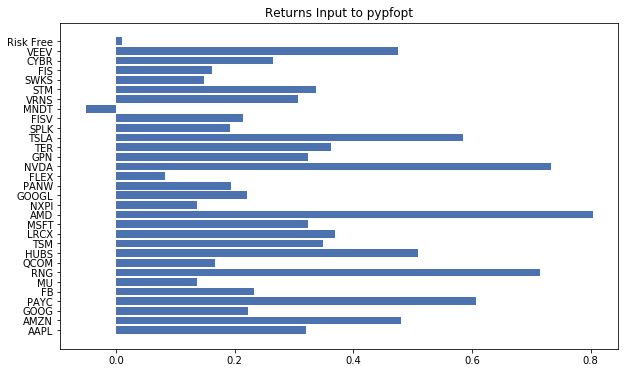

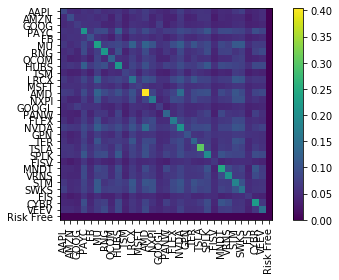

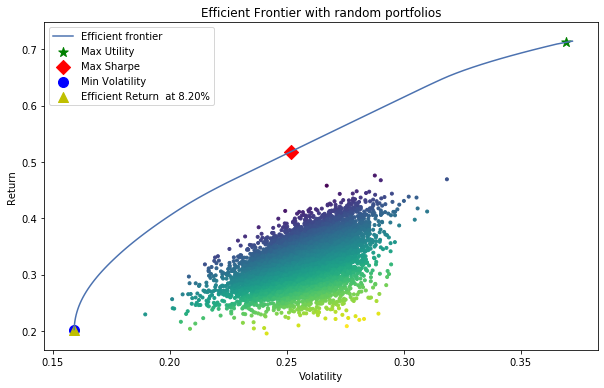

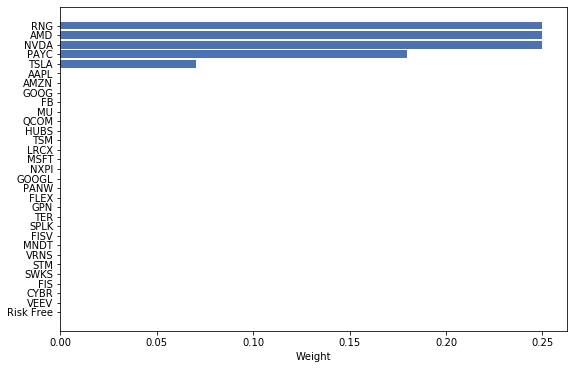

In [10]:
# Basic returns with default settings
ef_qn2 = po.get_optimal_portfolio()

# 3.7: Adding Constraints

## Function for Mapper 

In [11]:
# Helper function
def get_stock_info(stocks_list):
    """
    get stock info 
    """
    results = {}
    for stock in stocks_list:
        info = yf.Ticker(stock).info
        results[stock] = info
    return results 

def get_region_stocks(stocks_list, stock_info):
    '''
    returns a dict of the stock where the company is based in
    '''
    results = {}
    for stock in stocks_list:
        if stock == 'Risk Free':
          results[stock] = "NIL"
          continue
        country = stock_info[stock]["country"]
        if country != "United States":
          country = "Others"
        results[stock] = country 
    return results 

def get_sector_stocks(stocks_list, stock_info):
    '''
    returns a dict of the sector of the stock 
    '''
    results = {}
    for stock in stocks_list:
        if stock == "Risk Free":
            results[stock] = "NIL"
            continue
        industry = stock_info[stock]["industry"]
        if "Semiconductors" in industry or "Semiconductor" in industry:
            industry = "Semiconductors"
        elif industry == 'Internet Content & Information':
            industry = 'Communication Services'        
        results[stock] = industry
    return results 

def determine_growth_or_value_stocks(stocks_list,stock_info):
    '''
    returns a dict of the PEG ratio of the stock to determine whether value / growth stock
    '''
    results = {}
    for stock in stocks_list:
        # To be removed if we can get pegratio for MNDT
        if stock == 'MNDT': # To account for ticker name change from FEYE to MDNT
          stock_info[stock]['pegRatio']=-0.59
        if stock == "Risk Free":
            results[stock] = "NIL"
            continue
        peg_ratio = stock_info[stock]["pegRatio"]
        if peg_ratio > 1:
            results[stock] = 'Growth Stock'
        else:
            results[stock] = 'Value Stock'
    return results 

In [12]:
# get the stock information
is_colab = False
if is_colab:
    stock_info = get_stock_info(tickers) 

In [13]:
if is_colab:
    sector_mapper = get_sector_stocks(tickers, stock_info) 
else: 
    sector_mapper  = {'AAPL': 'Consumer Electronics',
    'AMD': 'Semiconductors',
    'AMZN': 'Internet Retail',
    'CYBR': 'Software—Infrastructure',
    'FB': 'Communication Services',
    'FIS': 'Information Technology Services',
    'FISV': 'Information Technology Services',
    'FLEX': 'Electronic Components',
    'GOOG': 'Communication Services',
    'GOOGL': 'Communication Services',
    'GPN': 'Specialty Business Services',
    'HUBS': 'Software—Application',
    'LRCX': 'Semiconductors',
    'MNDT': 'Software—Infrastructure',
    'MSFT': 'Software—Infrastructure',
    'MU': 'Semiconductors',
    'NVDA': 'Semiconductors',
    'NXPI': 'Semiconductors',
    'PANW': 'Software—Infrastructure',
    'PAYC': 'Software—Application',
    'QCOM': 'Semiconductors',
    'RNG': 'Software—Application',
    'Risk Free': 'NIL',
    'SPLK': 'Software—Infrastructure',
    'STM': 'Semiconductors',
    'SWKS': 'Semiconductors',
    'TER': 'Semiconductors',
    'TSLA': 'Auto Manufacturers',
    'TSM': 'Semiconductors',
    'VEEV': 'Health Information Services',
    'VRNS': 'Software—Infrastructure'}
sector_lower = {"Communication Services": 0.4}  # at least 40% to communication services
sector_upper = {"Semiconductors":0.2} # maximum 20% to semiconductors lower from 25% to 20%

In [14]:
if is_colab:
    region_mapper = get_region_stocks(tickers, stock_info)
else:
    region_mapper = {'AAPL': 'United States',
    'AMD': 'United States',
    'AMZN': 'United States',
    'CYBR': 'Others',
    'FB': 'United States',
    'FIS': 'United States',
    'FISV': 'United States',
    'FLEX': 'Others',
    'GOOG': 'United States',
    'GOOGL': 'United States',
    'GPN': 'United States',
    'HUBS': 'United States',
    'LRCX': 'United States',
    'MNDT': 'United States',
    'MSFT': 'United States',
    'MU': 'United States',
    'NVDA': 'United States',
    'NXPI': 'Others',
    'PANW': 'United States',
    'PAYC': 'United States',
    'QCOM': 'United States',
    'RNG': 'United States',
    'Risk Free': 'NIL',
    'SPLK': 'United States',
    'STM': 'Others',
    'SWKS': 'United States',
    'TER': 'United States',
    'TSLA': 'United States',
    'TSM': 'Others',
    'VEEV': 'United States',
    'VRNS': 'United States'}

region_lower = {'Others': 0.20}  # at least 20% to stocks outside of US 
region_upper = {} 

In [15]:
if is_colab:
    growval_mapper = determine_growth_or_value_stocks(tickers, stock_info) 
else:
    growval_mapper = {'AAPL': 'Growth Stock',
    'AMD': 'Growth Stock',
    'AMZN': 'Growth Stock',
    'CYBR': 'Value Stock',
    'FB': 'Value Stock',
    'FIS': 'Growth Stock',
    'FISV': 'Growth Stock',
    'FLEX': 'Value Stock',
    'GOOG': 'Growth Stock',
    'GOOGL': 'Growth Stock',
    'GPN': 'Value Stock',
    'HUBS': 'Growth Stock',
    'LRCX': 'Growth Stock',
    'MNDT': 'Value Stock',
    'MSFT': 'Growth Stock',
    'MU': 'Value Stock',
    'NVDA': 'Growth Stock',
    'NXPI': 'Growth Stock',
    'PANW': 'Growth Stock',
    'PAYC': 'Growth Stock',
    'QCOM': 'Value Stock',
    'RNG': 'Growth Stock',
    'Risk Free': 'NIL',
    'SPLK': 'Growth Stock',
    'STM': 'Growth Stock',
    'SWKS': 'Growth Stock',
    'TER': 'Growth Stock',
    'TSLA': 'Growth Stock',
    'TSM': 'Growth Stock',
    'VEEV': 'Growth Stock',
    'VRNS': 'Growth Stock'}
growval_lower = {"Value Stock": 0.2} # Prolly keep this 
growval_upper = {"Value Stock": 0.6} # If can find article we can keep this constraint


In [16]:
cap_mapper = {
    'AAPL': "Large-cap",
    'AMZN': "Large-cap",
    'GOOG': "Large-cap",
    'PAYC': "Large-cap",
    'FB': "Large-cap",
    'MU': "Large-cap",
    'RNG': "Large-cap",
    'QCOM': "Large-cap",
    'HUBS': "Large-cap",
    'TSM': "Large-cap",
    'LRCX': "Large-cap",
    'MSFT': "Large-cap",
    'AMD': "Large-cap",
    'NXPI': "Large-cap",
    'GOOGL': "Large-cap",
    'STM': "Large-cap",
    'PANW': "Large-cap",
    'FLEX': "Mid-cap",
    'NVDA': "Large-cap",
    'GPN': "Large-cap",
    'TER': "Large-cap",
    'TSLA': "Large-cap",
    'SPLK': "Large-cap",
    'FISV': "Large-cap",
    'MNDT': "Mid-cap",
    'VRNS': "Mid-cap",
    'STM': "Large-cap",
    'SWKS': "Large-cap",
    'FIS': "Large-cap",
    'CYBR': "Mid-cap",
    "VEEV": "Large-cap",
    "Risk Free" :"NIL"
}
cap_lower = {}  
cap_upper = {"Large-cap": 0.90} # at most 90% to large cap 100% to 90%

In [17]:
specific_ticker_mapper ={
    'AAPL': "AAPL",
    'AMZN': "AMZN",
    'GOOG': "GOOG",
    'PAYC': "PAYC",
    'FB': "FB",
    'MU': "MU",
    'RNG': "RNG",
    'QCOM': "QCOM",
    'HUBS': "HUBS",
    'TSM': "TSM",
    'LRCX': "LRCX",
    'MSFT': "MSFT",
    'AMD': "AMD",
    'NXPI': "NXPI",
    'GOOGL': "GOOGL",
    'STM': "STM",
    'PANW': "PANW",
    'FLEX': "FLEX",
    'NVDA': "NVDA",
    'GPN': "GPN",
    'TER': "TER",
    'TSLA': "TSLA",
    'SPLK': "SPLK",
    'FISV': "FISV",
    'MNDT': "MNDT",
    'VRNS': "VRNS",
    'STM': "STM",
    'SWKS': "SWKS",
    'FIS': "FIS",
    'CYBR': "CYBR",
    'VEEV': "VEEV",
    "Risk Free" :"Risk Free"
}

specific_ticker_lower = {"Risk Free" : 0.01, 
                         "AMZN" : 0.05}  
specific_ticker_upper = {}

# to be used for final model with EMA Historical mean only
specific_ticker_upper_TSLA = {"TSLA":0.1}

## Adding a Gamma function and Sector constraints

C:\Users\sid\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Expected annual return: 33.3%
Annual volatility: 24.5%
Sharpe Ratio: 1.32


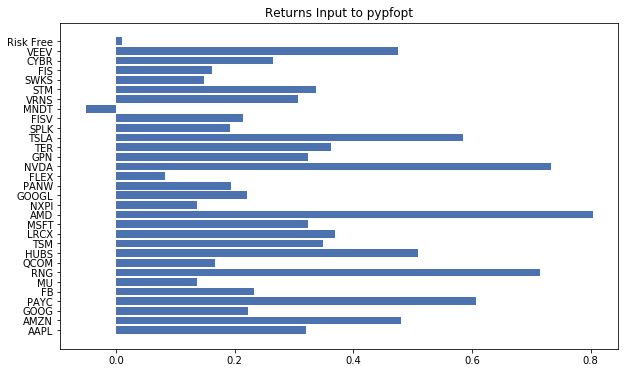

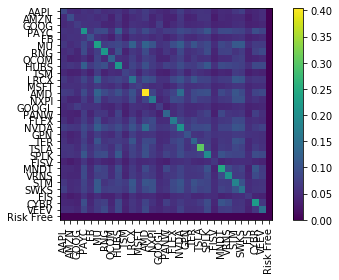

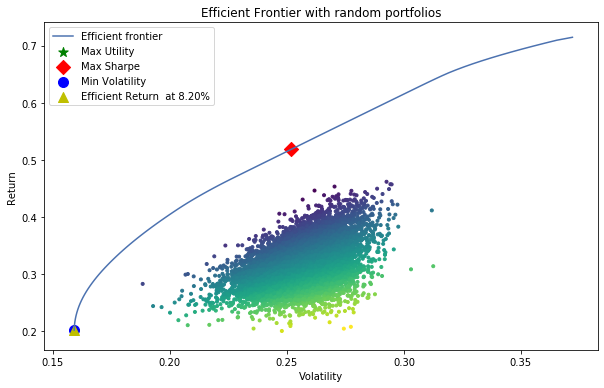

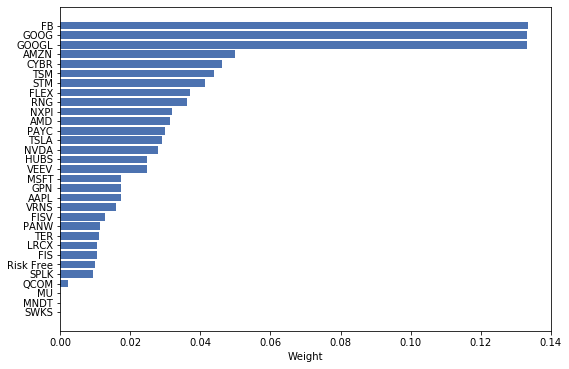

In [18]:
# add a gamma and sector, cap, and region constraint
ef_qn2_g_s = po.get_optimal_portfolio(gamma = 10, constraint_mapper = [sector_mapper, cap_mapper, region_mapper,growval_mapper, specific_ticker_mapper],
                                      constraint_lower = [sector_lower,cap_lower, region_lower,growval_lower , specific_ticker_lower], 
                                      constraint_upper = [sector_upper,cap_upper, region_upper,growval_upper , specific_ticker_upper], upper_weight_bound = 0.25)

# 3.9: Finding which method better models our Returns and Risk

In [19]:
from pypfopt import risk_models, expected_returns, plotting

In [20]:
df = PortfolioOptimizer.get_price_data_for_multiple_stocks(tickers, start_date="2015-01-01",end_date="2020-12-31")
past_df, future_df = df.iloc[:-250], df.iloc[-250:] # comparing the last 250 days with all the historical data 
future_cov = risk_models.sample_cov(future_df)

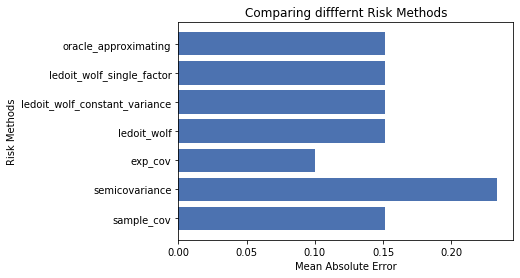

In [21]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.title('Comparing difffernt Risk Methods')
plt.xlabel("Mean Absolute Error")
plt.ylabel("Risk Methods")
plt.show()

Exp_cov seems to perform well

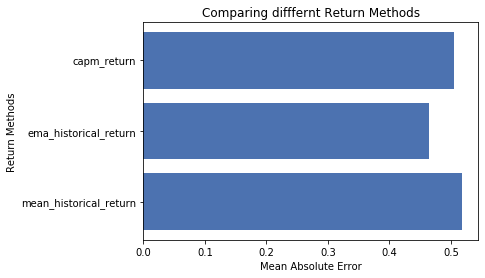

In [22]:
future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.title('Comparing difffernt Return Methods')
plt.xlabel("Mean Absolute Error")
plt.ylabel("Return Methods")
plt.show()

EMA historical seems to have the lowest errors

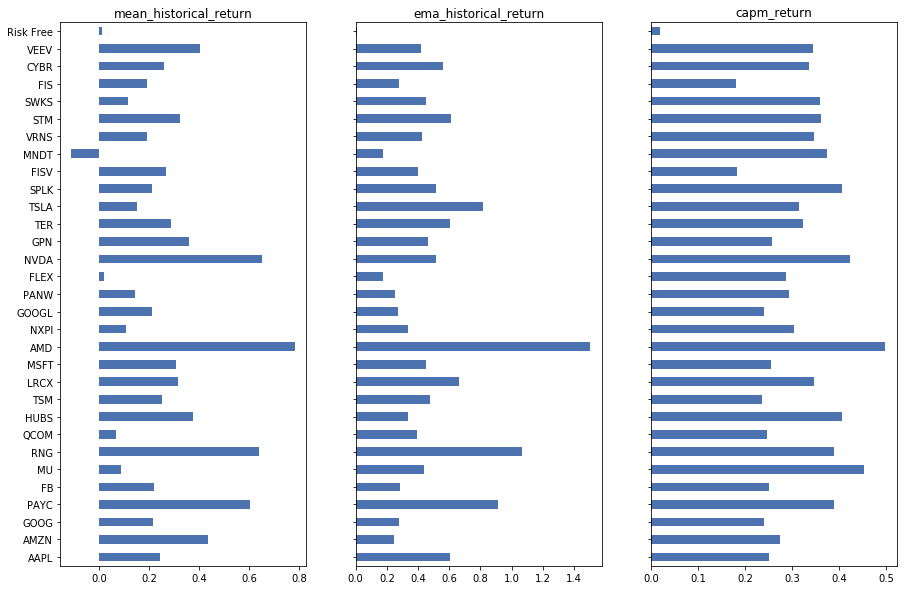

In [23]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])

Verdict: Use EMA since we are using data from the past 5 years

## Portfolio Optimaization with EMA and constraints 

Expected annual return: 111.6%
Annual volatility: 30.7%
Sharpe Ratio: 3.60


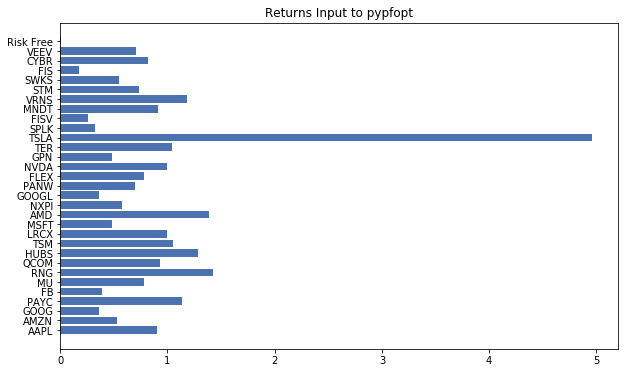

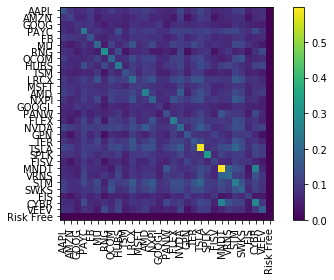

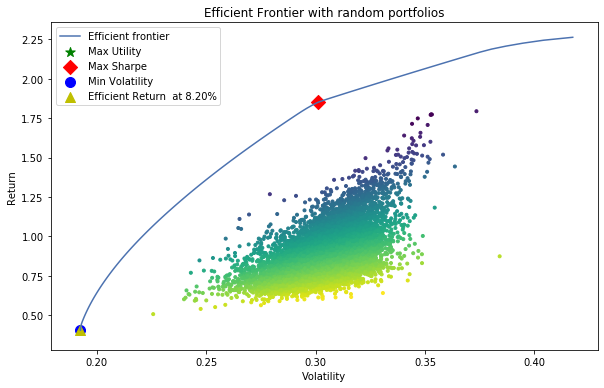

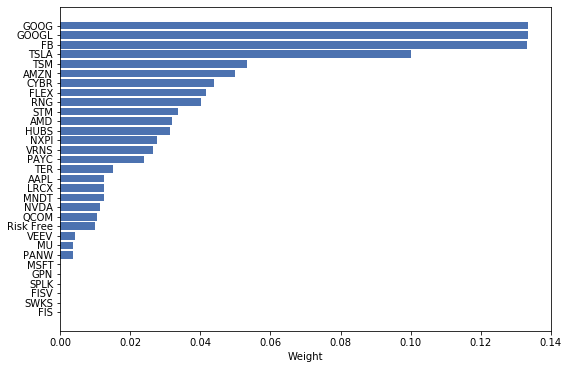

In [24]:
ef_qn2_g_s_ema = po.get_optimal_portfolio(expected_returns_function=expected_returns.ema_historical_return, cov_func=risk_models.exp_cov, 
                                          gamma = 10, 
                                          constraint_mapper = [sector_mapper, cap_mapper, region_mapper, growval_mapper, specific_ticker_mapper],
                                          constraint_lower = [sector_lower,cap_lower, region_lower,growval_lower , specific_ticker_lower], 
                                          constraint_upper = [sector_upper,cap_upper, region_upper,growval_upper , specific_ticker_upper_TSLA], upper_weight_bound = 0.25)

# 4: Value-at-Risk and Expected Shortfall



## Helper Functions to calculate VaR


In [25]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
def create_allocation_dict(portfolio_dict, end_date ="2020-12-31", total_portfolio_value= 5000000000):

    prices_df = PortfolioOptimizer.get_price_data_for_multiple_stocks(portfolio_dict.keys(), start_date = end_date, end_date =end_date) # Get the last day prices
    
    latest_prices = get_latest_prices(prices_df) # Gets the latest prices
    da = DiscreteAllocation(portfolio_dict, latest_prices, total_portfolio_value=total_portfolio_value) 
    allocation, leftover = da.lp_portfolio() # Find the integeter value to buy that still maintains the weight distribution 

    print(f'Allocation was not perfect and you have ${leftover:.2f} leftover')
    print(f'Amount invested is ${total_portfolio_value - leftover}')

    return allocation

In [26]:
import seaborn as sns
import math

def prepare_data(allocation_dict,start_date = "2020-01-01", end_date ="2020-12-31"):

    prices_df = PortfolioOptimizer.get_price_data_for_multiple_stocks(allocation_dict.keys(), start_date = start_date, end_date =end_date) # Pull the prices data from yahoo 
    allocation_df = pd.DataFrame(allocation_dict.values(), index = allocation_dict.keys(), columns= ['Shares Bought'])

    historical_portfolio_value_df = prices_df.dot(allocation_df) # Multiplying shares bought and price
    historical_portfolio_value_df.rename(columns ={'Shares Bought':'Portfolio Value'}, inplace=True)
    
    log_returns = PortfolioOptimizer.get_data_for_multiple_stocks(allocation_dict.keys(), start_date = start_date, end_date =end_date)
    log_returns.columns = [col_name+'_log_returns' for col_name in log_returns.columns]
    # Merge Log returns data 
    historical_portfolio_value_df = log_returns.merge(historical_portfolio_value_df, how = 'left', left_index=True, right_index=True)
    
    # Merge prices data 
    historical_portfolio_value_df = prices_df.merge(historical_portfolio_value_df, how = 'left', left_index=True, right_index=True)    

    # Finding portfolio returns in log space
    historical_portfolio_value_df["Portfolio Prev Value"] = historical_portfolio_value_df["Portfolio Value"].shift(1)
    historical_portfolio_value_df["Portfolio log_return"] = np.log(historical_portfolio_value_df['Portfolio Value']/historical_portfolio_value_df["Portfolio Prev Value"])
    
    historical_portfolio_value_df = historical_portfolio_value_df.iloc[1:] # Remove the first row that will be na
    
    for stock_ticker, stock_shares in allocation_dict.items():
        historical_portfolio_value_df[stock_ticker]
        historical_portfolio_value_df[f'{stock_ticker} Weight'] = (historical_portfolio_value_df[stock_ticker] * stock_shares)/ historical_portfolio_value_df['Portfolio Value']
    
    return historical_portfolio_value_df

### Rolling Historical VAR

In [27]:
def get_historical_VAR_of_Stocks(allocation_dict, start_date = "2020-01-01", end_date ="2020-12-31",  pVaR = 0.05, var_value = 95):
    historical_portfolio_value_df = prepare_data(allocation_dict, start_date = start_date, end_date =end_date)
    CLM_VaR2_ES = deepcopy(historical_portfolio_value_df)
    CLM_VaR2_ES.reset_index(inplace  = True)
    significance = pVaR # Significance level

    for i in range(0, len(CLM_VaR2_ES)):
        past_250 = CLM_VaR2_ES.loc[(i-249):(i), 'Portfolio log_return']
        past_250.dropna(inplace=True)
        if len(past_250) == 250:
            # VAR
            CLM_VaR2_ES.loc[i, f'VaR_{var_value}'] = past_250.quantile(significance)
            # ES
            log_returns_sorted = sorted(past_250.dropna())
            length = len(log_returns_sorted)
            cutoff_rt1_index = math.floor(length*significance +1) - 1 #minus one due to index starting from 0

            sum_rt1 = sum(log_returns_sorted[:cutoff_rt1_index])
            CLM_VaR2_ES.loc[i, f'sum_log_{var_value}'] = sum_rt1 
            CLM_VaR2_ES.loc[i, f'ES_{var_value}'] = sum_rt1/len(log_returns_sorted[:cutoff_rt1_index])
            CLM_VaR2_ES.loc[i,f'VaR_{var_value}_simple'] = np.exp(past_250.quantile(significance)) - 1
            CLM_VaR2_ES.loc[i,f'ES_{var_value}_simple'] = np.exp(sum_rt1/len(log_returns_sorted[:cutoff_rt1_index])) - 1

        else:
            CLM_VaR2_ES.loc[i, f'VaR_{var_value}'], CLM_VaR2_ES.loc[i, f'VaR_{var_value}_simple'] = np.NaN, np.NaN
            CLM_VaR2_ES.loc[i, f'ES_{var_value}'], CLM_VaR2_ES.loc[i, f'ES_{var_value}_simple'] = np.NaN, np.NaN


    return CLM_VaR2_ES

### Rolling Parametric VAR

In [28]:
def calculate_portfolio_stats_from_log_returns(log_returns_df, portfolio_weights_dict, ticker_returns_log_list):
    mean_stock_return = log_returns_df.mean() # Daily 
    weights =  np.array(list(portfolio_weights_dict.values())) # Get the weights

    # Calculating Weighted mean (Need to convert to simple returns first)
    returns =  np.exp(mean_stock_return.values) -1  
    mean_return = np.dot(weights,returns)
    mean_log_return = np.log(1 + mean_return)
    weighted_mean = mean_log_return

    Stock_return = log_returns_df.reset_index() 

    # Calculating Volatility (Need to convert to simple returns first)
    mat_df = Stock_return[ticker_returns_log_list].values # Removing the date collumn for matrix manuipilation
    vcv = np.cov(mat_df.T) 
    vcv_perc = np.exp(vcv)-1
    variance_perc = np.dot(weights, np.dot(vcv_perc, weights))
    variance = np.log(variance_perc+1)
    volatility = sqrt(variance)
    
    return weighted_mean, volatility

In [29]:
def get_parametric_VAR_of_stocks(allocation_dict, start_date = "2020-01-01", end_date ="2020-12-31",  pVaR = 0.05, var_value = 95):
    historical_portfolio_value_df = prepare_data(allocation_dict, start_date = start_date, end_date =end_date)
    CLM_VaR2_ES = deepcopy(historical_portfolio_value_df)
    CLM_VaR2_ES.reset_index(inplace  = True)
    confidence = 1-pVaR # Confidence level
    z_alpha = norm.ppf(pVaR, loc=0, scale=1) # z-score

    ticker_returns_log_list = [ticker+'_log_returns' for ticker in allocation_dict.keys()]
    ticker_all_list = [ticker+' Weight' for ticker in allocation_dict.keys()]
    ticker_all_list.extend(ticker_returns_log_list)

    for i in range(0, len(CLM_VaR2_ES)):
        past_250 = CLM_VaR2_ES.loc[(i-249):(i), ticker_all_list]
        past_250.dropna(inplace=True)
        if len(past_250) == 250:
            # Calculate weights based on previous day prices
            portfolio_weights_dict = {}
            for ticker in allocation_dict.keys():
                portfolio_weights_dict[ticker] = past_250.iloc[-1][f'{ticker} Weight']

            mu, sigma = calculate_portfolio_stats_from_log_returns(past_250[ticker_returns_log_list], portfolio_weights_dict, ticker_returns_log_list)
            # VaR caculation
            CLM_VaR2_ES.loc[i, f'VaR_{var_value}'] = mu+sigma*z_alpha
            CLM_VaR2_ES.loc[i, f'VaR_{var_value}_simple'] =  np.exp(mu+sigma*z_alpha) - 1
            
            # Expected Shortfall
            CLM_VaR2_ES.loc[i, f'ES_{var_value}'] = mu+sigma*norm.pdf(norm.ppf(confidence, loc=0, scale=1), loc=0, scale=1)/(1-confidence) # returns a positive number
            
            # since it was computed as positive number we have to convert back to original negative
            CLM_VaR2_ES.loc[i, f'ES_{var_value}_simple'] = np.exp(-(mu+sigma*norm.pdf(norm.ppf(confidence, loc=0, scale=1), loc=0, scale=1)/(1-confidence))) - 1
            
        else:
            CLM_VaR2_ES.loc[i, f'VaR_{var_value}'], CLM_VaR2_ES.loc[i, f'VaR_{var_value}_simple'] = np.NaN, np.NaN
            CLM_VaR2_ES.loc[i, f'ES_{var_value}'], CLM_VaR2_ES.loc[i, f'ES_{var_value}_simple'] = np.NaN, np.NaN
            

    return CLM_VaR2_ES

In [30]:
def generate_parametric_historical_var(portfolio_dict, returns_start_date = "2020-01-01", returns_end_date ="2020-12-31", 
                                         total_portfolio_value= 5000000000, plot_graph_bool= True, sig = 0.05):
    var_value = int((1-sig)*100.0)
    
    allocation_dict_portfolio = create_allocation_dict(portfolio_dict, end_date = returns_start_date, total_portfolio_value= total_portfolio_value)

    print('\n\nHistorical')
    returns_df_rolling_historical_var_ES_portfolio = get_historical_VAR_of_Stocks(allocation_dict_portfolio,start_date =returns_start_date, end_date =returns_end_date, pVaR=sig, var_value = var_value)

    if plot_graph_bool == True:
        # Plot VaR_95
        plt.figure(figsize=(15,10))
        plt.plot(returns_df_rolling_historical_var_ES_portfolio['Date'], -returns_df_rolling_historical_var_ES_portfolio[f'VaR_{var_value}_simple'], 'r--', label=f'VaR Historical ({var_value}%)')
        plt.plot(returns_df_rolling_historical_var_ES_portfolio['Date'], -returns_df_rolling_historical_var_ES_portfolio[f'ES_{var_value}_simple'], 'y--', label=f'ES Historical ({var_value}%)')
        plt.grid(True)
        plt.xlabel('Date')
        plt.ylabel('Value At Risk')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=45)
        plt.title('Value-at-Risk and Expected Shortfall Using Historical Simulation Method', fontsize=20)
        plt.show()

    print('\n\nParametric')
    returns_df_parametric_rolling_var_ES_portfolio  = get_parametric_VAR_of_stocks(allocation_dict_portfolio,start_date = returns_start_date, end_date =returns_end_date, pVaR=sig, var_value = var_value)

        # Plot VaR_95
    if plot_graph_bool == True:
        plt.figure(figsize=(15,10))
        plt.plot(returns_df_parametric_rolling_var_ES_portfolio['Date'], -returns_df_parametric_rolling_var_ES_portfolio[f'VaR_{var_value}_simple'], 'r--', label=f'VaR Parametric({var_value}%)')
        plt.plot(returns_df_parametric_rolling_var_ES_portfolio['Date'], -returns_df_parametric_rolling_var_ES_portfolio[f'ES_{var_value}_simple'], 'y--', label=f'ES Parametric({var_value}%)')
        plt.grid(True)
        plt.xlabel('Date')
        plt.ylabel('Value At Risk')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=45)
        plt.title('Value-at-Risk and Expected Shortfall Using Parametric Method', fontsize=20)
        plt.show()

    return returns_df_rolling_historical_var_ES_portfolio,returns_df_parametric_rolling_var_ES_portfolio 

## Own Portfolio VaR

In [31]:
portfolio_to_use = ef_qn2_g_s_ema
# Filter out zero weights
portfolio_dict_own_portfolio = {}
for i in range(len(portfolio_to_use.weights)):
    if ef_qn2_g_s_ema.weights[i] > 0 :
        portfolio_dict_own_portfolio[portfolio_to_use.tickers[i]] = portfolio_to_use.weights[i]

print(portfolio_dict_own_portfolio)

{'AAPL': 0.0125353020190027, 'AMZN': 0.05, 'GOOG': 0.1334360395799403, 'PAYC': 0.0238418435969061, 'FB': 0.1331690995167302, 'MU': 0.0037828620953598, 'RNG': 0.0401059057170334, 'QCOM': 0.0105535167091634, 'HUBS': 0.031336542842342, 'TSM': 0.0533870279003755, 'LRCX': 0.0125251530478954, 'AMD': 0.032013388827096, 'NXPI': 0.0275332997322931, 'GOOGL': 0.1333948609033295, 'PANW': 0.0036221045770153, 'FLEX': 0.0416767574622884, 'NVDA': 0.0114775467721592, 'TER': 0.0151716447406356, 'TSLA': 0.1, 'MNDT': 0.0124182396842147, 'VRNS': 0.0263734620809324, 'STM': 0.0335555601750219, 'CYBR': 0.0438473547300211, 'VEEV': 0.0042424872902439, 'Risk Free': 0.01}


Allocation was not perfect and you have $0.05 leftover
Amount invested is $4999999999.945177


Historical


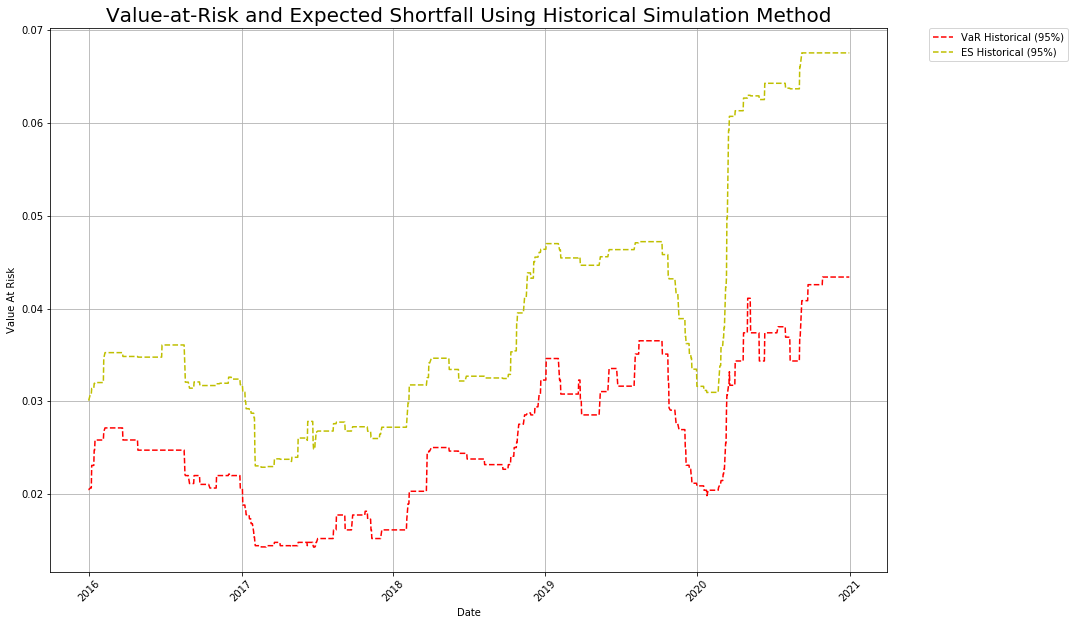



Parametric


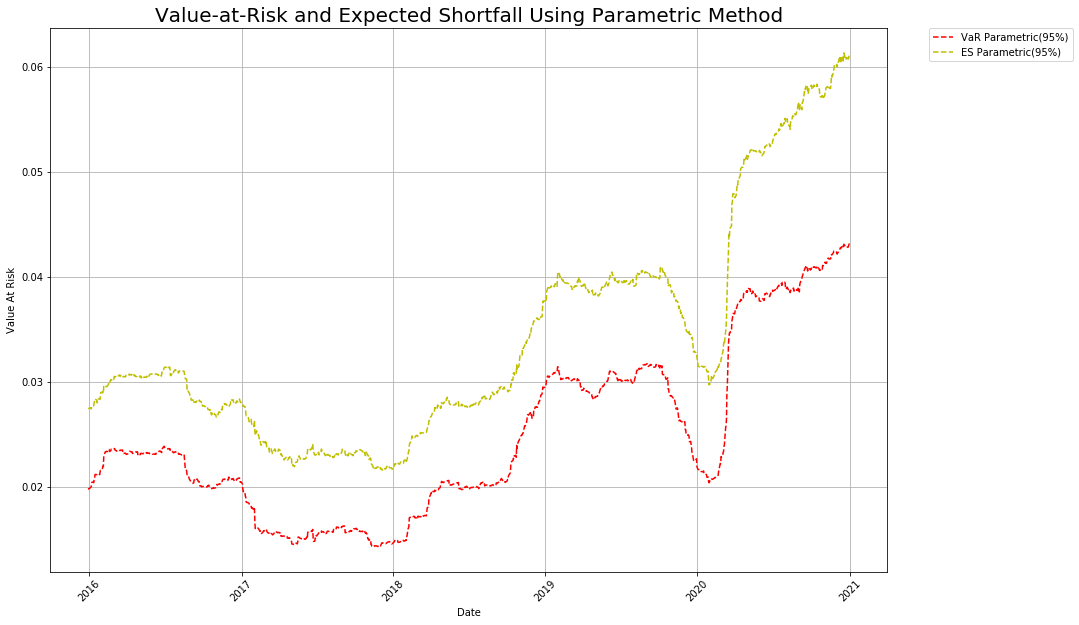

In [32]:
returns_df_rolling_historical_var_ES_own_portfolio,returns_df_parametric_rolling_var_ES_own_portfolio  = generate_parametric_historical_var(
                                            portfolio_dict_own_portfolio, returns_start_date = "2015-01-02", returns_end_date ="2020-12-31", sig = 0.05)

## Best Portfolio  VaR

Allocation was not perfect and you have $0.66 leftover
Amount invested is $4999999999.340099


Historical


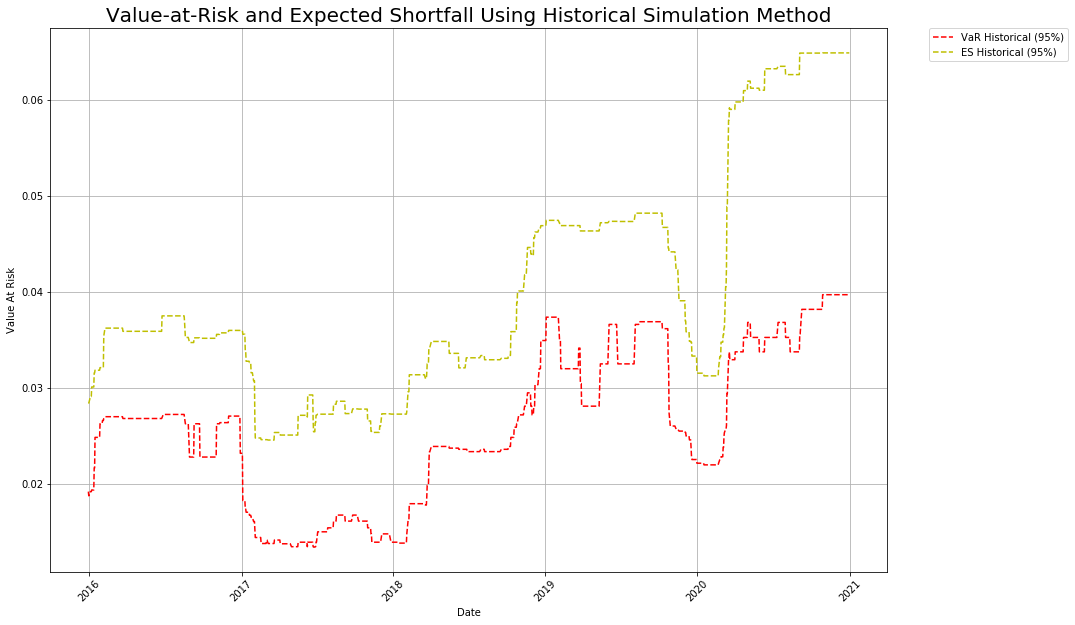



Parametric


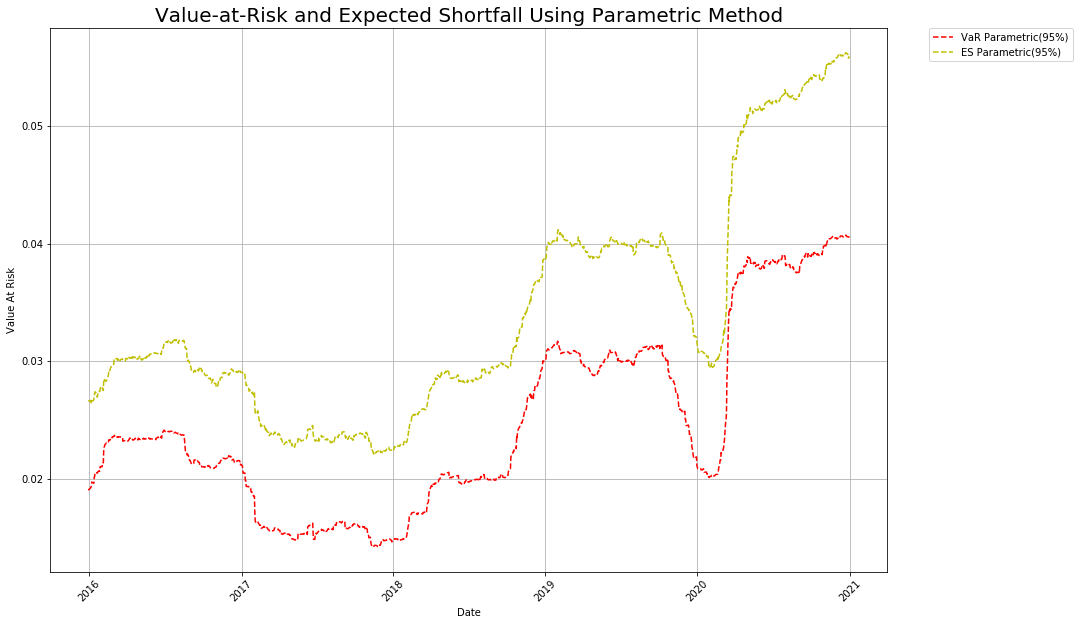

In [33]:
returns_df_rolling_historical_var_ES_best_portfolio,returns_df_parametric_rolling_var_ES_best_portfolio  = generate_parametric_historical_var(
                                            portfolio_dict_best_portfolio, returns_start_date = "2015-01-02", returns_end_date ="2020-12-31", sig = 0.05)

## Worst Portfolio  VaR

Allocation was not perfect and you have $8.78 leftover
Amount invested is $4999999991.219293


Historical


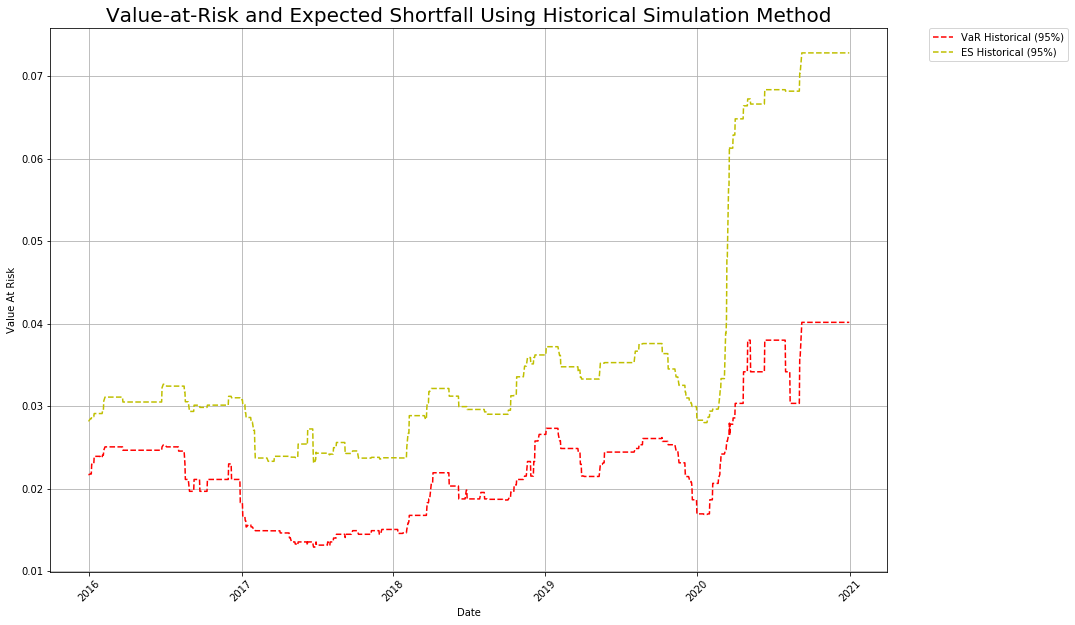



Parametric


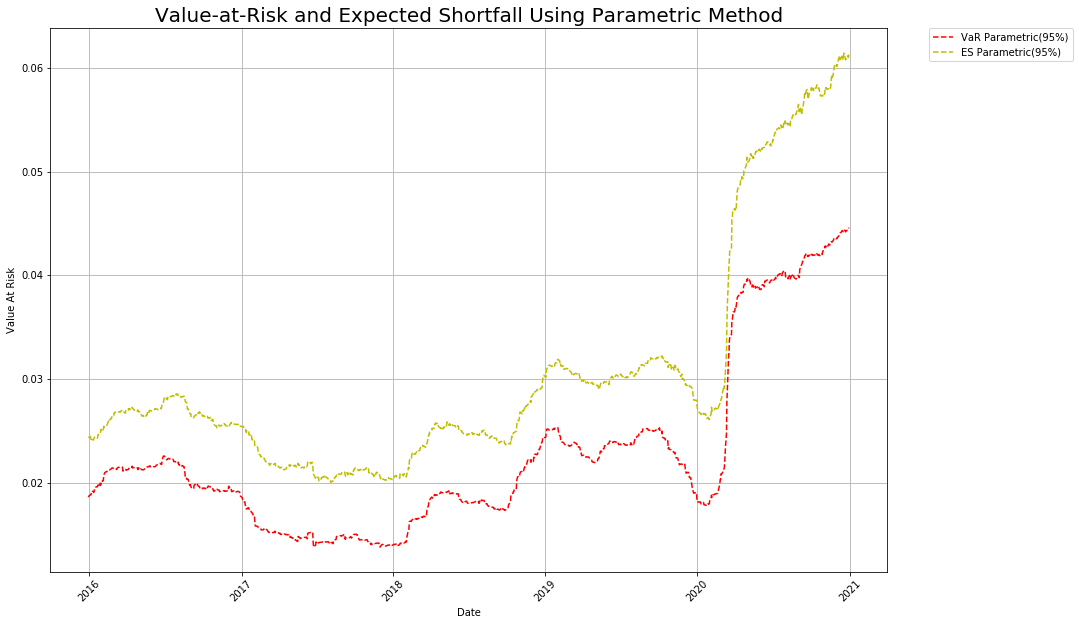

In [34]:
returns_df_rolling_historical_var_ES_worst_portfolio,returns_df_parametric_rolling_var_ES_worst_portfolio  = generate_parametric_historical_var(
                                            portfolio_dict_worst_portfolio, returns_start_date = "2015-01-02", returns_end_date ="2020-12-31", sig = 0.05)

# 5: Best Method for Value-at-Risk

### Helper Functions for Testing Methods

In [35]:
def get_historical_VAR_of_Stocks_enhanced(allocation_dict, time_decay_factor, start_date = "2019-01-01", end_date ="2020-12-31", rolling_window_size = 250):
    historical_portfolio_value_df = prepare_data(allocation_dict, start_date = start_date, end_date = end_date)
    CLM_VaR2_ES = deepcopy(historical_portfolio_value_df)
    CLM_VaR2_ES.reset_index(inplace  = True)
    CLM_VaR2_ES['time'] = [i for i in range(len(CLM_VaR2_ES))]
    significance = 0.05 # Significance level
        
    for i in range(0, len(CLM_VaR2_ES)):
        past_data = CLM_VaR2_ES.loc[(i-(rolling_window_size-1)):(i), ['Portfolio log_return','time']]
        past_data.dropna(inplace=True)
        if len(past_data) == rolling_window_size:
            past_data_copy = deepcopy(past_data.sort_values('Portfolio log_return'))
            past_data_copy.reset_index(inplace= True)
            past_data_copy['recency score'] = abs(past_data_copy['time'] - past_data_copy['time'].max()) + 1 # reversing the order so that returns that are more recent are higher weighted
            past_data_copy['weights'] = past_data_copy['recency score'].apply(lambda x: ( (time_decay_factor**(x-1))*(1-time_decay_factor) )/(1-time_decay_factor**rolling_window_size))
            past_data_copy['CUMSUM_Weights'] = past_data_copy['weights'].cumsum()
            for index, row in past_data_copy.iterrows():
                if row['CUMSUM_Weights'] > significance: 
                    CLM_VaR2_ES.loc[i, 'VaR_95'] = past_data_copy.loc[max(0,index),'Portfolio log_return'] # get the return right after the significance level
                    CLM_VaR2_ES.loc[i, 'VaR_95_simple'] =  np.exp(past_data_copy.loc[max(0,index),'Portfolio log_return']) - 1
                    break
        else:
            CLM_VaR2_ES.loc[i, 'VaR_95'], CLM_VaR2_ES.loc[i, 'VaR_95_simple'] = np.NaN, np.NaN

    return CLM_VaR2_ES

In [36]:
from scipy.stats import binom_test
def binomial_test(var_col, failures, observations, backtesting_alpha = 0.05, var_significance = 0.05 ):
    
    p_value = p_value = binom_test(failures, observations, var_significance, alternative = 'two-sided')
    
    print(f"P-value of {var_col}: ", p_value)
    if(p_value < backtesting_alpha):
        print(f"Reject null hypothesis at {backtesting_alpha} backtesting significance level for Unconditional (Bionomial) Test")
    else:
        print(f"Not enough evidence to reject null hypothesis at {backtesting_alpha} backtesting significance level under binomial distribution ")
    

In [37]:
def independance_test(data,var_col,failures,observations, backtesting_alpha = 0.05):
    #Independance test 
    data['ind_t1'] = data['ind_t'].shift(-1)

    data['ind_00'] = data.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==0 else 0, axis=1)
    data['ind_10'] = data.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==0 else 0, axis=1)
    data['ind_01'] = data.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==1 else 0, axis=1)
    data['ind_11'] = data.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==1 else 0, axis=1)
    data.dropna(inplace=True)

    # calculate all parameters to conduct z-test 
    N00, N10, N01, N11 = data[['ind_00','ind_10','ind_01','ind_11']].sum(axis=0)
    # total days of 1 and 0 
    total_1 = data[data["ind_t"] == 1].shape[0]
    total_0 = data[data["ind_t"] == 0].shape[0]
    p = failures / observations
    p1 = N11 / failures
    p2 = N01 / (observations - total_1)

    diff_in_proportion = (p1-p2)
    variance = (p)*(1-p)*((1/total_1)+(1/total_0))
    Z = diff_in_proportion / sqrt(variance)
    
    # 2 tail test 
    z_alpha = norm.ppf(backtesting_alpha/2, loc=0, scale=1) #Using normal Dist
    positive_z_alpha = z_alpha * -1
    negative_z_alpha = z_alpha
    print(f"Z-value of {var_col} = {Z} and z_alpha = +{negative_z_alpha}")
    if Z > positive_z_alpha or Z < negative_z_alpha:
        print(f'Reject null hypothesis at {backtesting_alpha} backtesting significance level for Independance Test')
    else:
        print(f'Not enough evidence to reject null hypothesis at {backtesting_alpha} backtesting significance level')

In [38]:
def binomial_and_independance_test(data, var_col, backtesting_alpha = 0.05, var_significance = 0.05, date_from = '2021-01-01', date_to = "2021-06-30", plot_bool= True):
    
    CLM_VaR2 = deepcopy(data)
    CLM_VaR2 = CLM_VaR2[(CLM_VaR2.Date >= date_from) & (CLM_VaR2.Date <= date_to)] 
    
    CLM_VaR2['ind_t'] = CLM_VaR2.apply(lambda row: 1 if row[var_col]>row['log_return_next_day'] else 0, axis=1)
    
    observed_level = 1 - len(CLM_VaR2[CLM_VaR2[var_col]>CLM_VaR2['log_return_next_day']])/len(CLM_VaR2)
    observations = len(CLM_VaR2)
    failures = len(CLM_VaR2[CLM_VaR2[var_col]>CLM_VaR2['log_return_next_day']])
    expected = observations*var_significance
    
    print(f'Number of observations: {observations}') 
    print(f'Number of failures: {failures}')
    print(f'Number of expected: {expected}')

    if plot_bool:
        # Plot: Returns vs VaR
        plt.figure(figsize=(15,10))
        plt.plot(CLM_VaR2['Date'], -CLM_VaR2[var_col], 'b--', label=f'{var_col}')
        plt.plot(CLM_VaR2['Date'], -CLM_VaR2['log_return_next_day'], 'y-', label='Returns (in Loss)')
        plt.scatter(CLM_VaR2['Date'], -CLM_VaR2['log_return_next_day'],c = -CLM_VaR2['ind_t'], label='Scatterplot of returns colored by failure (in Loss)')
        plt.grid(True)
        plt.xlabel('Date')
        plt.ylabel(f'Returns (in Loss) and {var_col}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=45)
        plt.title(f'Returns (in Loss) vs {var_col}', fontsize = 20)
        plt.show()
        
    if failures == 0:
        print(f"Failures = 0, cannot conduct independence test")
        return
    
    print('\nBionomial Test')
    binomial_test(var_col, failures, observations, backtesting_alpha = backtesting_alpha, var_significance = var_significance)
    
    print('\nIndependance Test')
    independance_test(CLM_VaR2, var_col,failures,observations-1, backtesting_alpha =backtesting_alpha) # one less obervation
    

In [39]:
def all_in_one_function(portfolio_dict, allocation_end_date ="2020-12-31", returns_start_date = "2019-01-01", returns_end_date = "2021-06-30", 
                        backtesting_alpha  = 0.05, var_significance = 0.05, testing_start_date = '2021-01-01', total_portfolio_value= 5000000000):
    portfolio_allocation = create_allocation_dict(portfolio_dict, end_date = allocation_end_date, total_portfolio_value= total_portfolio_value)

    var_value = int((1-var_significance)*100.0)
    print('\n\nHistorical')
    returns_df_rolling_historical_var_ES_portfolio = get_historical_VAR_of_Stocks(portfolio_allocation,start_date =returns_start_date, end_date =returns_end_date, pVaR=var_significance,var_value=var_value)
    returns_df_rolling_historical_var_ES_portfolio["log_return_next_day"] = returns_df_rolling_historical_var_ES_portfolio["Portfolio log_return"].shift(-1)
    binomial_and_independance_test(returns_df_rolling_historical_var_ES_portfolio, f'VaR_{var_value}', backtesting_alpha=backtesting_alpha,var_significance=var_significance,date_from = testing_start_date, date_to = returns_end_date)

    print('\n\nParametric')
    returns_df_parametric_rolling_var_ES_portfolio  = get_parametric_VAR_of_stocks(portfolio_allocation,start_date = returns_start_date, end_date =returns_end_date, pVaR=var_significance,var_value=var_value)
    returns_df_parametric_rolling_var_ES_portfolio["log_return_next_day"] = returns_df_parametric_rolling_var_ES_portfolio["Portfolio log_return"].shift(-1)
    binomial_and_independance_test(returns_df_parametric_rolling_var_ES_portfolio, f'VaR_{var_value}', backtesting_alpha=backtesting_alpha,var_significance=var_significance,date_from = testing_start_date, date_to = returns_end_date)

    print('\n\nWeighted Historical Simulation')
    returns_df_rolling_whs_var_portfolio = get_historical_VAR_of_Stocks_enhanced(portfolio_allocation, time_decay_factor=0.98, start_date = returns_start_date, end_date =returns_end_date, rolling_window_size = 280)
    returns_df_rolling_whs_var_portfolio['log_return_next_day'] = returns_df_rolling_whs_var_portfolio['Portfolio log_return'].shift(-1)
    binomial_and_independance_test(returns_df_rolling_whs_var_portfolio, f'VaR_{var_value}', backtesting_alpha=backtesting_alpha,var_significance=var_significance,date_from = testing_start_date, date_to = returns_end_date)
    
    return returns_df_rolling_historical_var_ES_portfolio, returns_df_parametric_rolling_var_ES_portfolio, returns_df_rolling_whs_var_portfolio


## Comparing all portfolios

To make the testing more robust we add another method that is Weighted Historical Simulation for VaR. The reason for not choosing ES as a measure is becuase it is difficult to perform unconditional testing on it. Hence the we have gone with WHS and will be testing 3 VaR methods for all 3 portfolios

### Own Portfolio Independance Testing

Allocation was not perfect and you have $19.19 leftover
Amount invested is $4999999980.805892


Historical
Number of observations: 124
Number of failures: 5
Number of expected: 6.2


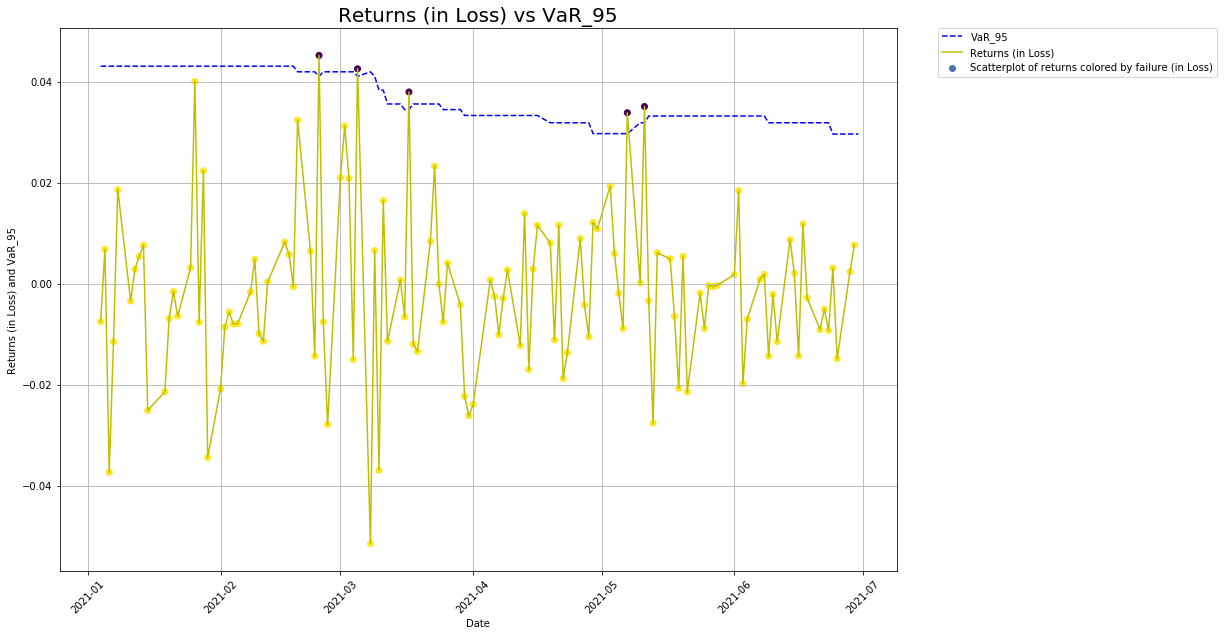


Bionomial Test
P-value of VaR_95:  0.835913383938846
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.46993798755972105 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


Parametric
Number of observations: 124
Number of failures: 5
Number of expected: 6.2


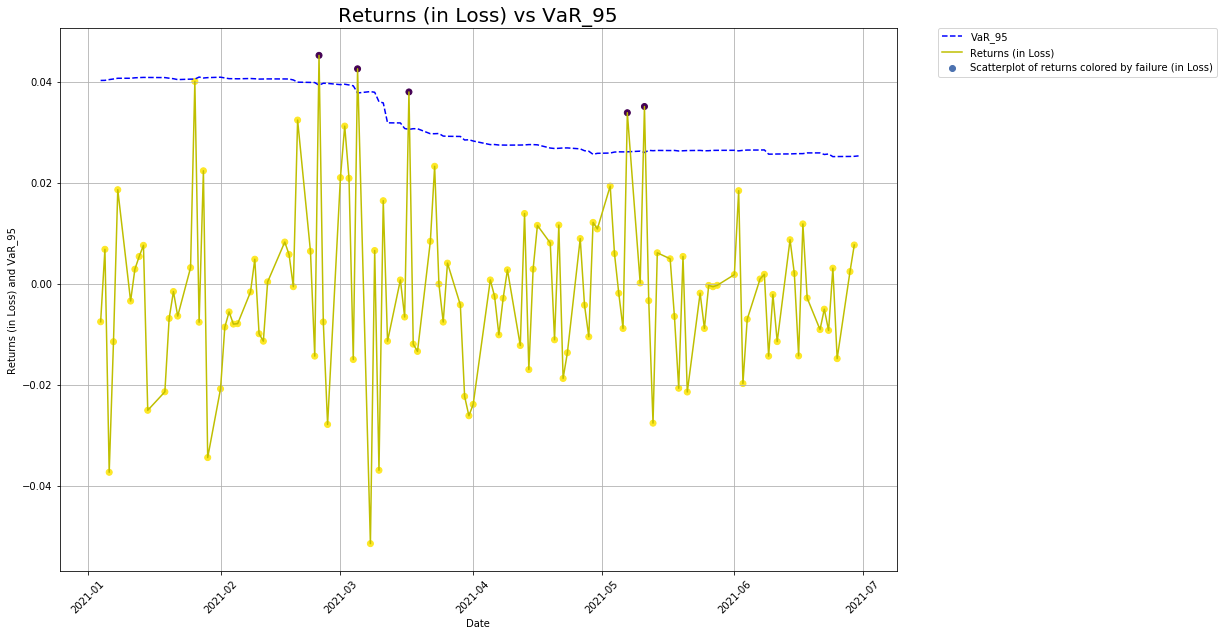


Bionomial Test
P-value of VaR_95:  0.835913383938846
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.46993798755972105 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


Weighted Historical Simulation
Number of observations: 124
Number of failures: 6
Number of expected: 6.2


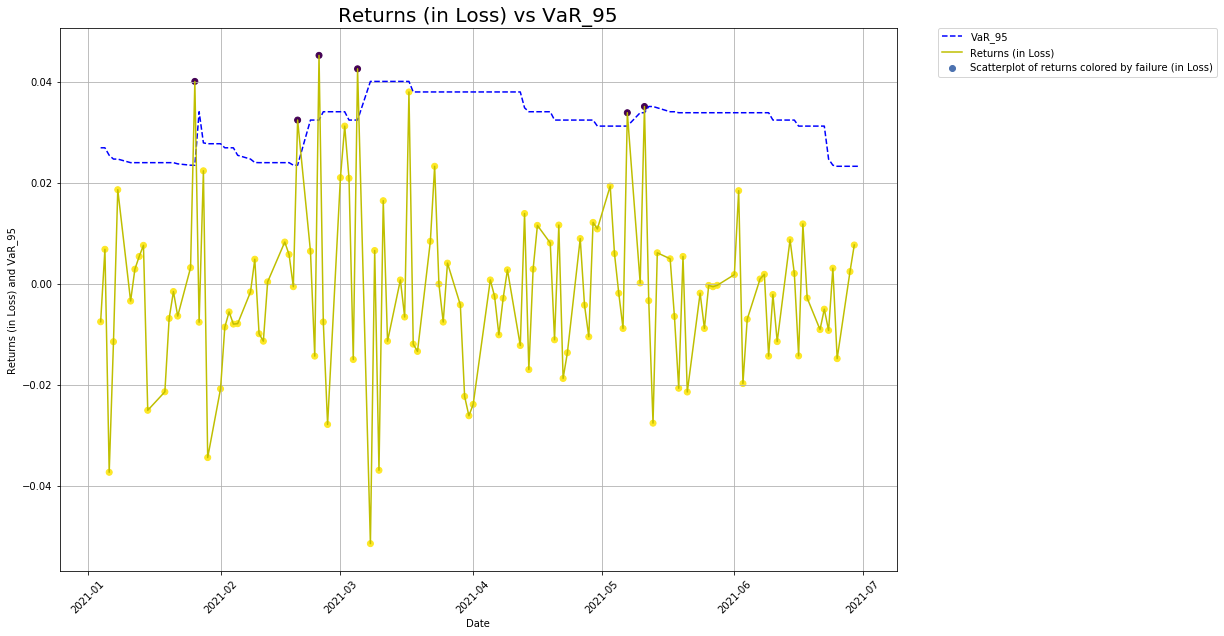


Bionomial Test
P-value of VaR_95:  1.0
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.5687454618671496 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


In [40]:
own_hist_var, own_para_var, own_whs_var = all_in_one_function(portfolio_dict_own_portfolio, backtesting_alpha  = 0.05, var_significance = 0.05)

### Best Portfolio Independance Testing

Allocation was not perfect and you have $125.60 leftover
Amount invested is $4999999874.404113


Historical
Number of observations: 124
Number of failures: 4
Number of expected: 6.2


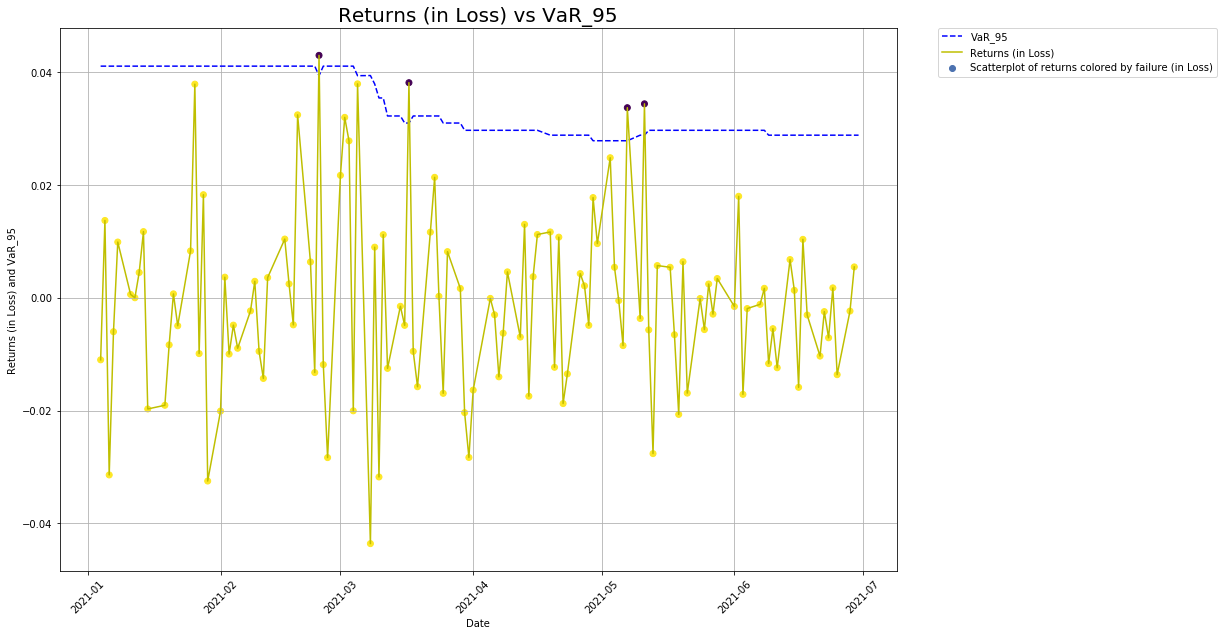


Bionomial Test
P-value of VaR_95:  0.5331405567795678
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.37279114307258543 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


Parametric
Number of observations: 124
Number of failures: 5
Number of expected: 6.2


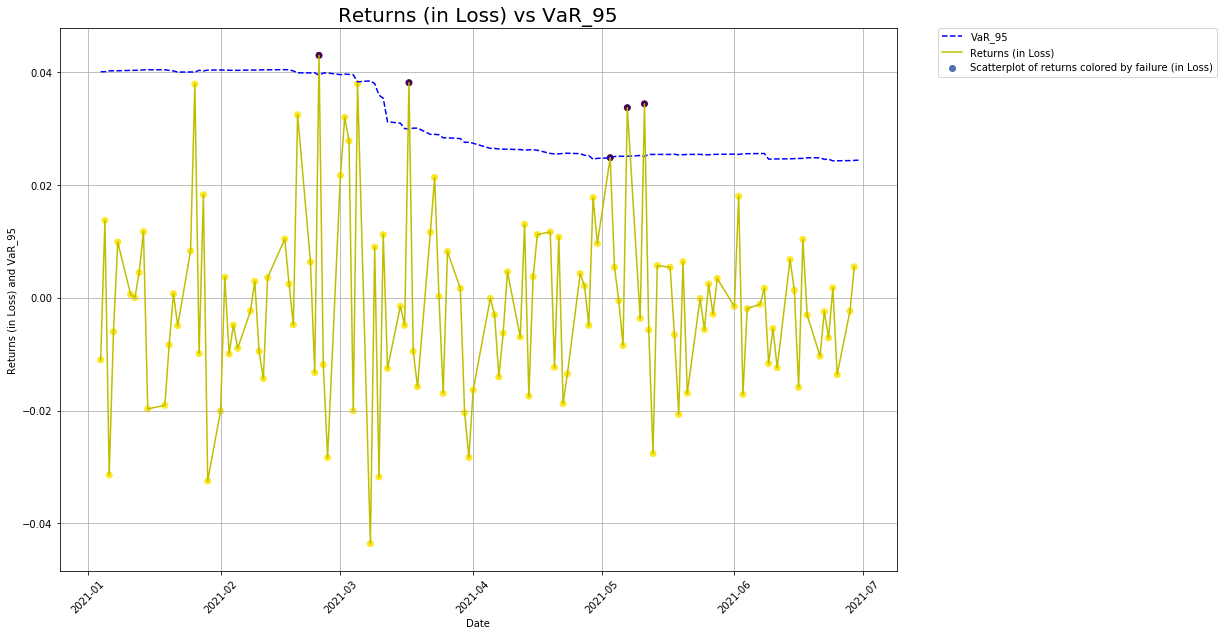


Bionomial Test
P-value of VaR_95:  0.835913383938846
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.46993798755972105 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


Weighted Historical Simulation
Number of observations: 124
Number of failures: 7
Number of expected: 6.2


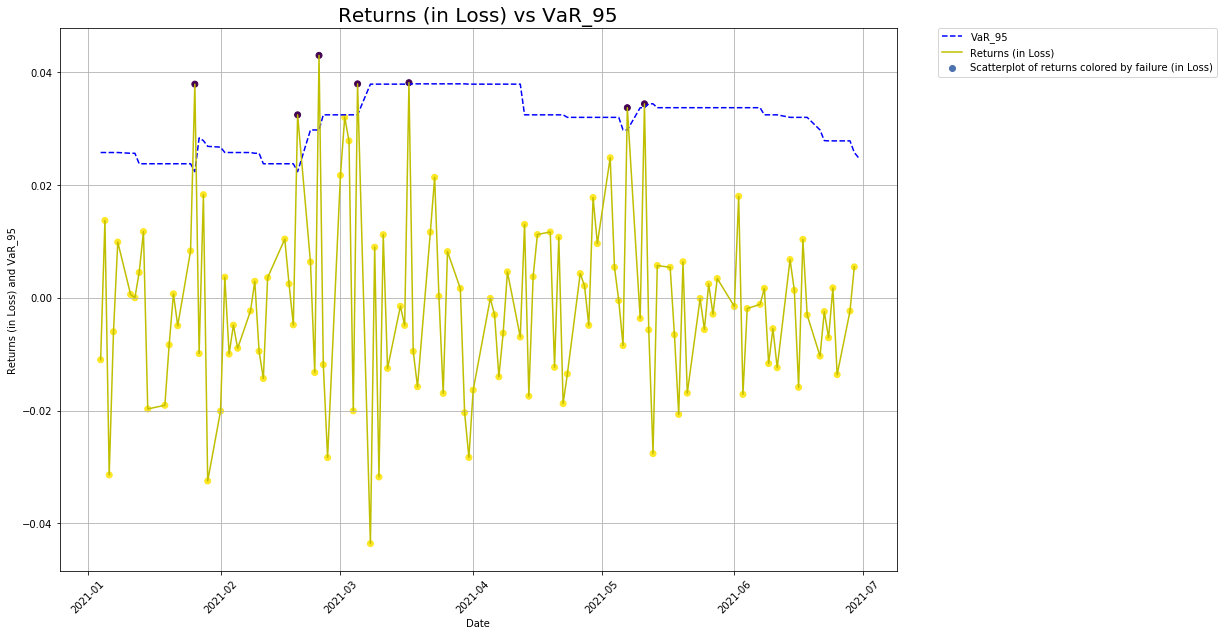


Bionomial Test
P-value of VaR_95:  0.6787211635105157
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.6692565133178097 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


In [41]:
best_hist_var, best_para_var, best_whs_var = all_in_one_function(portfolio_dict_best_portfolio,backtesting_alpha  = 0.05, var_significance = 0.05)

### Worst Portfolio Independance Testing

Allocation was not perfect and you have $2.29 leftover
Amount invested is $4999999997.709206


Historical
Number of observations: 124
Number of failures: 4
Number of expected: 6.2


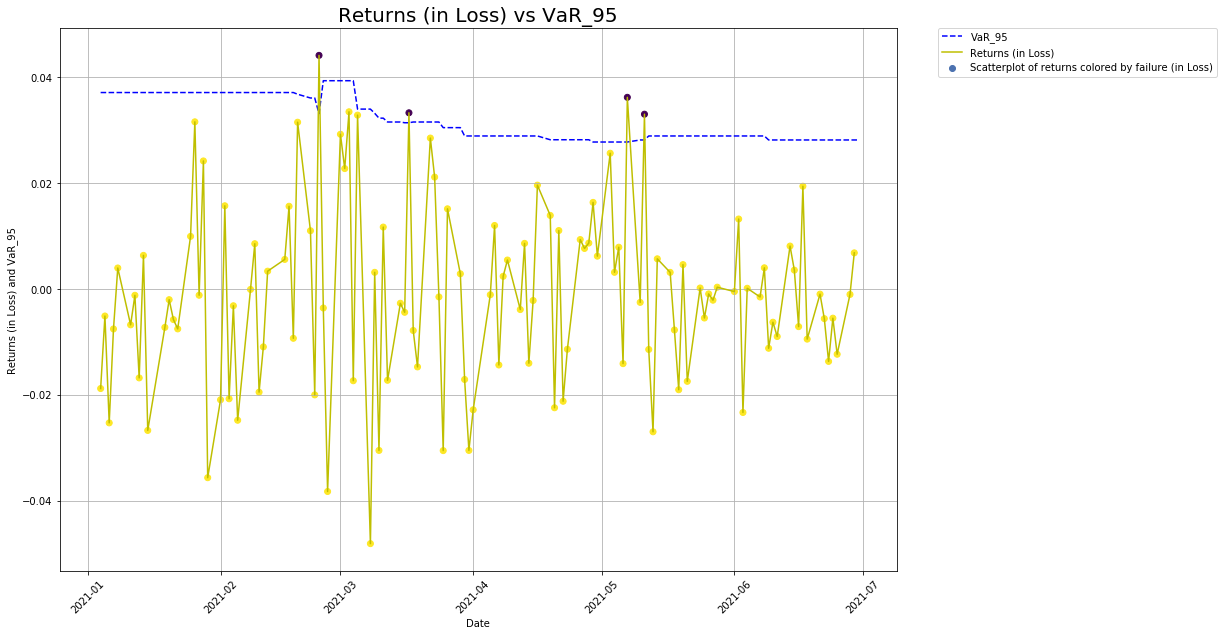


Bionomial Test
P-value of VaR_95:  0.5331405567795678
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.37279114307258543 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


Parametric
Number of observations: 124
Number of failures: 4
Number of expected: 6.2


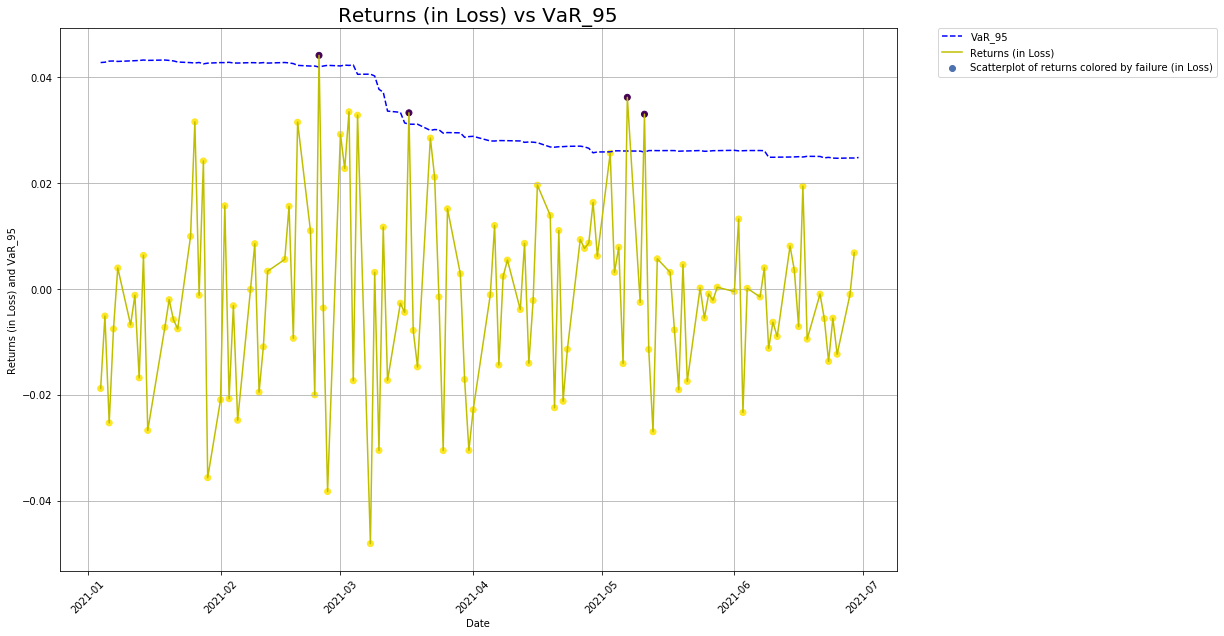


Bionomial Test
P-value of VaR_95:  0.5331405567795678
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.37279114307258543 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


Weighted Historical Simulation
Number of observations: 124
Number of failures: 8
Number of expected: 6.2


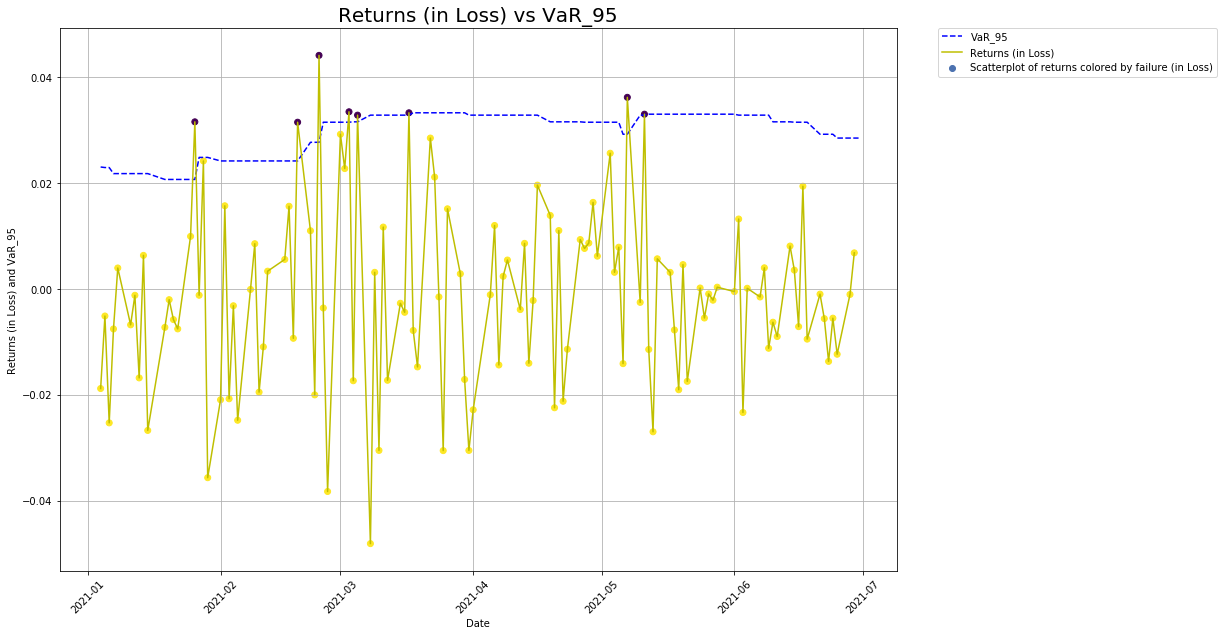


Bionomial Test
P-value of VaR_95:  0.4086967156071398
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution 

Independance Test
Z-value of VaR_95 = -0.7715155830545681 and z_alpha = +-1.9599639845400545
Not enough evidence to reject null hypothesis at 0.05 backtesting significance level


In [42]:
worst_hist_var, worst_para_var, worst_whs_var = all_in_one_function(portfolio_dict_worst_portfolio,backtesting_alpha  = 0.05, var_significance = 0.05)

### Comparing VaR on Key Periods for all portfolios and methods

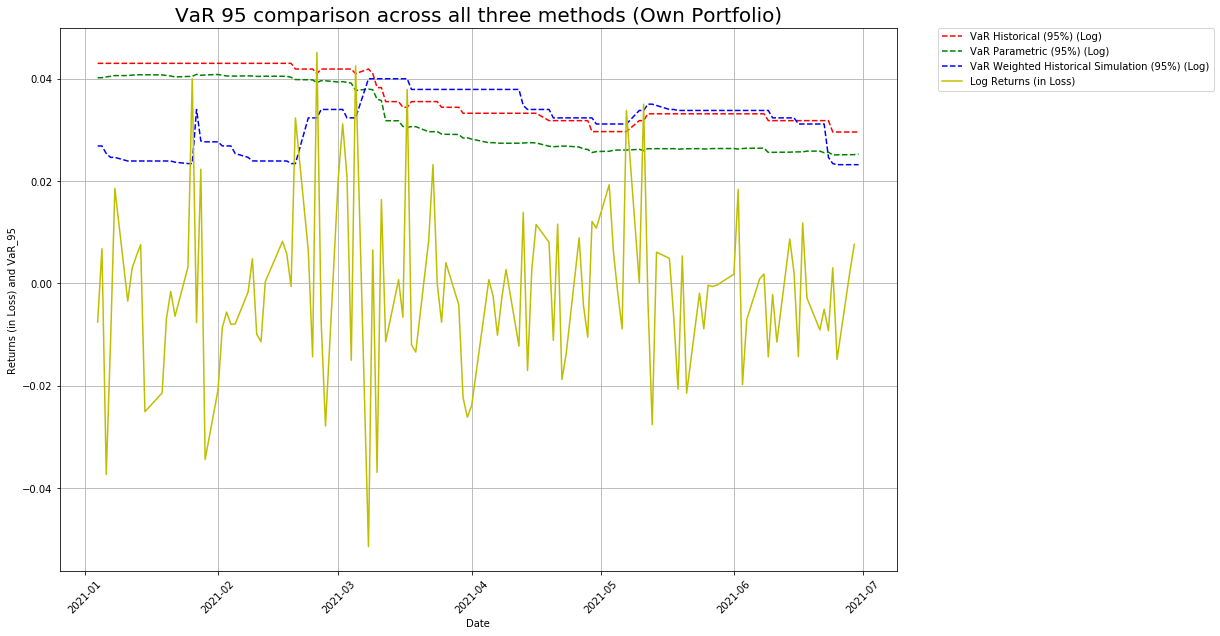

In [43]:
plt.figure(figsize=(15,10))
own_hist_var_2021 = own_hist_var[(own_hist_var.Date >= '2021-01-01') & (own_hist_var.Date <= '2021-06-30')]
own_para_var_2021 = own_para_var[(own_para_var.Date >= '2021-01-01') & (own_para_var.Date <= '2021-06-30')]
own_whs_var_2021 = own_whs_var[(own_whs_var.Date >= '2021-01-01') & (own_whs_var.Date <= '2021-06-30')]
plt.plot(own_hist_var_2021['Date'], -own_hist_var_2021['VaR_95'], 'r--', label='VaR Historical (95%) (Log)')
plt.plot(own_para_var_2021['Date'], -own_para_var_2021['VaR_95'], 'g--', label='VaR Parametric (95%) (Log)')
plt.plot(own_whs_var_2021['Date'], -own_whs_var_2021['VaR_95'], 'y--', label='VaR Weighted Historical Simulation (95%) (Log)', color = 'b')
plt.plot(own_whs_var_2021['Date'], -own_whs_var_2021['log_return_next_day'], 'y-', label='Log Returns (in Loss)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel(f'Returns (in Loss) and VaR_95')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title(f'VaR 95 comparison across all three methods (Own Portfolio)', fontsize = 20)
plt.show()

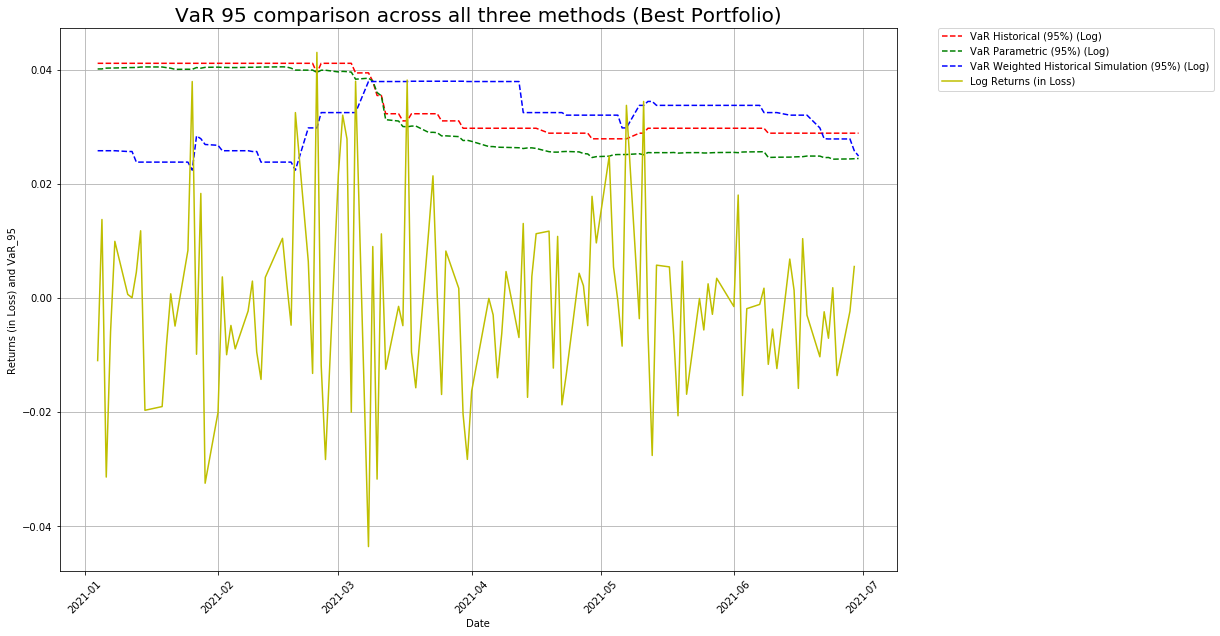

In [44]:
plt.figure(figsize=(15,10))
best_hist_var_2021 = best_hist_var[(best_hist_var.Date >= '2021-01-01') & (best_hist_var.Date <= '2021-06-30')]
best_para_var_2021 = best_para_var[(best_para_var.Date >= '2021-01-01') & (best_para_var.Date <= '2021-06-30')]
best_whs_var_2021 = best_whs_var[(best_whs_var.Date >= '2021-01-01') & (best_whs_var.Date <= '2021-06-30')]
plt.plot(best_hist_var_2021['Date'], -best_hist_var_2021['VaR_95'], 'r--', label='VaR Historical (95%) (Log)')
plt.plot(best_para_var_2021['Date'], -best_para_var_2021['VaR_95'], 'g--', label='VaR Parametric (95%) (Log)')
plt.plot(best_whs_var_2021['Date'], -best_whs_var_2021['VaR_95'], 'y--', label='VaR Weighted Historical Simulation (95%) (Log)', color = 'b')
plt.plot(best_whs_var_2021['Date'], -best_whs_var_2021['log_return_next_day'], 'y-', label='Log Returns (in Loss)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel(f'Returns (in Loss) and VaR_95')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title(f'VaR 95 comparison across all three methods (Best Portfolio)', fontsize = 20)
plt.show()

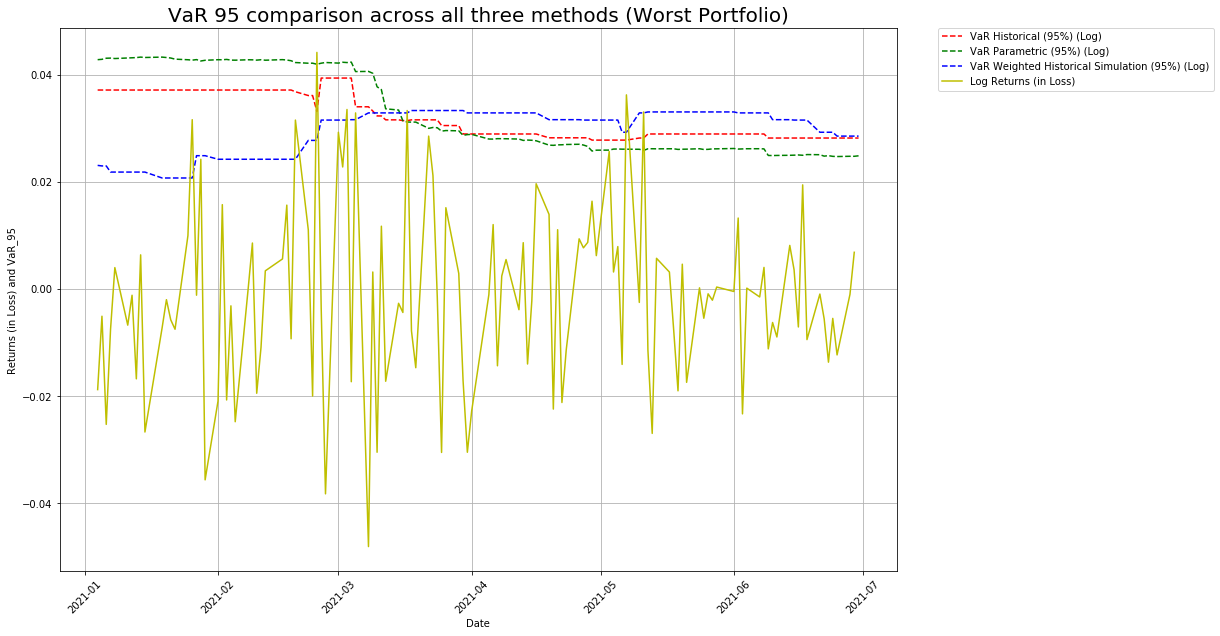

In [45]:
plt.figure(figsize=(15,10))
worst_hist_var_2021 = worst_hist_var[(worst_hist_var.Date >= '2021-01-01') & (worst_hist_var.Date <= '2021-06-30')]
worst_para_var_2021 = worst_para_var[(worst_para_var.Date >= '2021-01-01') & (worst_para_var.Date <= '2021-06-30')]
worst_whs_var_2021 = worst_whs_var[(worst_whs_var.Date >= '2021-01-01') & (worst_whs_var.Date <= '2021-06-30')]
plt.plot(worst_hist_var_2021['Date'], -worst_hist_var_2021['VaR_95'], 'r--', label='VaR Historical (95%) (Log)')
plt.plot(worst_para_var_2021['Date'], -worst_para_var_2021['VaR_95'], 'g--', label='VaR Parametric (95%) (Log)')
plt.plot(worst_whs_var_2021['Date'], -worst_whs_var_2021['VaR_95'], 'y--', label='VaR Weighted Historical Simulation (95%) (Log)', color = 'b')
plt.plot(worst_whs_var_2021['Date'], -worst_whs_var_2021['log_return_next_day'], 'y-', label='Log Returns (in Loss)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel(f'Returns (in Loss) and VaR_95')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title(f'VaR 95 comparison across all three methods (Worst Portfolio)', fontsize = 20)
plt.show()

# 6: Adjusting Optimal Portfolio

## Finding what stocks were good in the first quarter of 2021

In [48]:
# Fetch data up till end September 2021
po_final = PortfolioOptimizer(0.01, "2021-01-01", "2021-09-30",  1.7376, tickers) 

# Sum log-returns from start of 2021 to end Sept 2021 and get top 5 stocks with best performance
print("Top 5 Best Performing Stocks 2021 Q1-Q3 (Annualised Log-Returns)")
print(po_final.get_data_for_multiple_stocks(tickers, start_date = "2021-01-01", end_date ="2021-09-30").sum(axis=0, skipna = True).nlargest(5))
print("\n")
# Sum log-returns from start of 2021 to end Sept 2021 and get top 5 stocks with worst performance
print("Top 5 Worst Performing Stocks 2021 Q1-Q3 (Annualised Log-Returns)")
print(po_final.get_data_for_multiple_stocks(tickers, start_date = "2021-01-01", end_date ="2021-09-30").sum(axis=0, skipna = True).nsmallest(5))

Top 5 Best Performing Stocks 2021 Q1-Q3 (Annualised Log-Returns)
HUBS     0.533802
NVDA     0.462486
GOOGL    0.422273
GOOG     0.419631
PANW     0.298485
dtype: float64


Top 5 Worst Performing Stocks 2021 Q1-Q3 (Annualised Log-Returns)
RNG    -0.555258
GPN    -0.309237
MNDT   -0.258901
SPLK   -0.160419
QCOM   -0.151967
dtype: float64


## 6.1 Dividend Discount Model

In [49]:
stock = 'SWKS'

In [50]:
import requests
import pandas as pd
# Retrieving stock dividend using Polygon.io external API 
api = 'Rr5Z9eiKSNkMuzNwqnFcosSoA0RYKGkc' 
dividend_api_url = f'https://api.polygon.io/v2/reference/dividends/{stock}?apiKey={api}'

dividend_data = requests.get(dividend_api_url).json()
dividends_df = pd.DataFrame(dividend_data['results'])
dividends_df['paymentDate'] = pd.to_datetime(dividends_df['paymentDate'])

# drop other columns as dividends calculated on annual basis
dividends_df = dividends_df.drop(['exDate', 'recordDate', 'declaredDate'], axis = 1)
dividends_df = dividends_df.set_index('paymentDate').resample('Y').sum()
dividends_df = dividends_df.groupby('paymentDate').agg({'amount':'sum'}).reset_index()
dividends_df.loc[7,'amount'] = 2.27 

# Calculating compounded annual growth rate of stock dividend
first_yr_div = dividends_df.iloc[0]['amount']
current_yr_div = dividends_df.iloc[-1]['amount']
stock_div_g = (current_yr_div/first_yr_div)**(1/len(dividends_df))-1

print(dividends_df)
print('\n')
print(f"{stock}'s Dividend Growth Rate (g): {stock_div_g}")

# Next year's projected stock dividend
stock_div_2022 = (1 + stock_div_g) * dividends_df['amount'].values[-1]
print(f"{stock}'s 2022 Dividend: {stock_div_2022}")


  paymentDate  amount
0  2014-12-31    0.35
1  2015-12-31    0.78
2  2016-12-31    1.08
3  2017-12-31    1.20
4  2018-12-31    1.40
5  2019-12-31    1.64
6  2020-12-31    1.88
7  2021-12-31    2.27


SWKS's Dividend Growth Rate (g): 0.26326576458560824
SWKS's 2022 Dividend: 2.867613285609331


In [51]:
import statsmodels.api as sm
import datetime as dt
def get_required_rate_of_return(ticker,rf = 0.01 ):
    # Taking the last 10 years of data for the chosen ticker and ^GSPC
    price_df_stock_snp = PortfolioOptimizer.get_price_data_for_multiple_stocks([ticker, '^GSPC'], start_date="2010-01-01",end_date="2020-01-01")
    ret_df_stock_snp = price_df_stock_snp.resample('Y').ffill().pct_change()
    ret_df_stock_snp.dropna(axis = 0, inplace = True)
    ret_df_stock_snp[f'{ticker}-rf'], ret_df_stock_snp['^GSPC-rf']  = ret_df_stock_snp[ticker] - rf, ret_df_stock_snp['^GSPC'] -rf
    y = ret_df_stock_snp[f'{ticker}-rf']
    X = ret_df_stock_snp['^GSPC-rf']
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm)
    results = model.fit()
    b = results.params['^GSPC-rf']
    print(f'Beta is: {b}')
    sns.regplot(x = '^GSPC', y = ticker, data = ret_df_stock_snp)
    market_returns = 1
    for index, row in ret_df_stock_snp.iterrows():
        market_returns*= 1+ row['^GSPC']
    geometric_average = (market_returns**(1/len(ret_df_stock_snp))) - 1
    rrr = rf + b*(geometric_average-rf)
    print(f'Required Rate of Return is: {rrr}')
    print(f'Geometric Average of SnP: {geometric_average}')
    return rrr

In [52]:
def share_price_valuation(rrr,g, current_dividend ):
    return (current_dividend*(1+g)) / (rrr-g)

Beta is: 2.617982761256185
Required Rate of Return is: 0.2776682470279339
Geometric Average of SnP: 0.11224217324467745


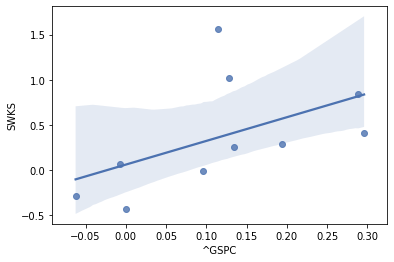

In [53]:
rrr = get_required_rate_of_return(stock)

In [54]:
share_price_valuation(rrr, stock_div_g, current_yr_div)

199.10548734168614

## Changing the returns based on recent news 

## 6.2 Using Black Litterman (BL) Model 

In [55]:
prices_sep_2021 = PortfolioOptimizer.get_price_data_for_multiple_stocks(tickers, start_date='2015-01-01',end_date="2021-09-30")

In [56]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

chosen_cov_method =  risk_models.exp_cov 
chosen_expected_returns_method = expected_returns.ema_historical_return 

s_with_RF_chosen_new = chosen_cov_method(prices_sep_2021)
market_prior_ema_new = chosen_expected_returns_method(prices_sep_2021)

In [57]:
viewdict_new_2021 = { 'AMZN': market_prior_ema_new['AMZN'] + 0.3,
                'AAPL': market_prior_ema_new['AAPL'] + 0.4,
                'AMD': market_prior_ema_new['AMD'] + 0.2,
                'FB': market_prior_ema_new['FB'] + 0.1,
                'MSFT': market_prior_ema_new['MSFT'] + 0.2,
                'GOOG': market_prior_ema_new['GOOG'] + 0.3,
                'GOOGL': market_prior_ema_new['GOOGL'] + 0.3,
                'SWKS': market_prior_ema_new['SWKS'] + 0.3,
                'RNG': market_prior_ema_new['RNG'] - 0.2,
                'HUBS': market_prior_ema_new['HUBS'] + 0.3
}
confidences_new_2021 = [0.7, 0.9, 0.9, 0.6, 0.7, 0.85, 0.9, 1.0, 0.9, 0.7]
assert len(viewdict_new_2021) == len(confidences_new_2021)

Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [58]:
bl_updated = BlackLittermanModel(s_with_RF_chosen_new, pi=market_prior_ema_new, absolute_views=viewdict_new_2021, omega="idzorek", view_confidences=confidences_new_2021)

In [59]:
# Posterior estimate of returns
ret_bl = bl_updated.bl_returns()

We can visualise how this compares to the prior and our views:

In [60]:
rets_df = pd.DataFrame([market_prior_ema_new, ret_bl, pd.Series(viewdict_new_2021)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.449481,0.812297,0.849481
AMZN,0.236131,0.494005,0.536131
GOOG,0.504913,0.790288,0.804913
PAYC,0.736191,0.964264,NaN
FB,0.355257,0.559587,0.455257
MU,0.247074,0.428614,NaN
RNG,0.055995,-0.093514,-0.144005
QCOM,0.248432,0.497654,NaN
HUBS,1.255155,1.501417,1.555155
TSM,0.426997,0.632487,NaN


Text(0.5, 1.0, 'Comparing how views change our prior returns')

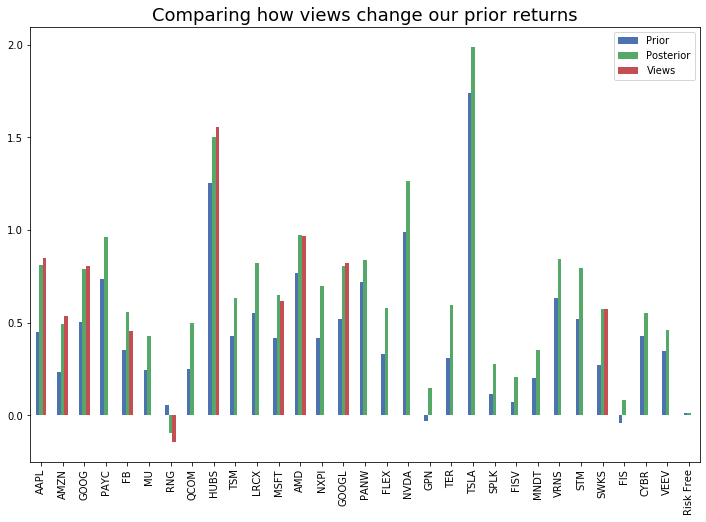

In [61]:
fig, ax = plt.subplots()
rets_df.plot.bar(figsize=(12,8), ax = ax)
ax.set_title('Comparing how views change our prior returns', fontsize = 18)

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

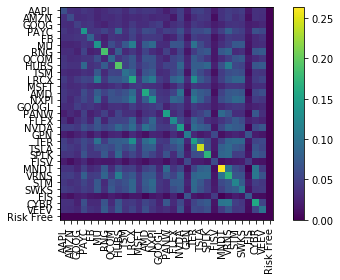

In [62]:
# posterior covariance estimate:
S_bl = bl_updated.bl_cov()
plotting.plot_covariance(S_bl);

C:\Users\sid\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Expected annual return: 87.4%
Annual volatility: 22.0%
Sharpe Ratio: 3.94


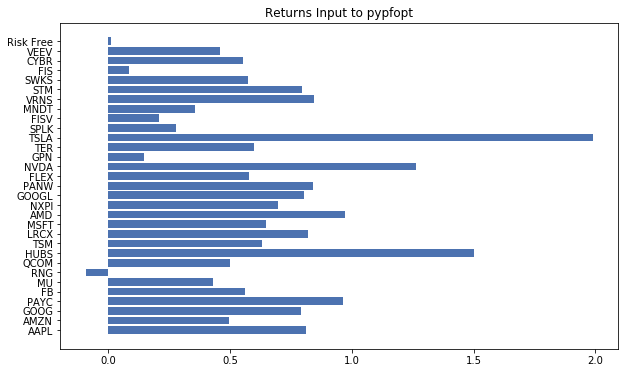

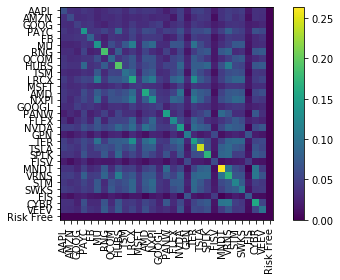

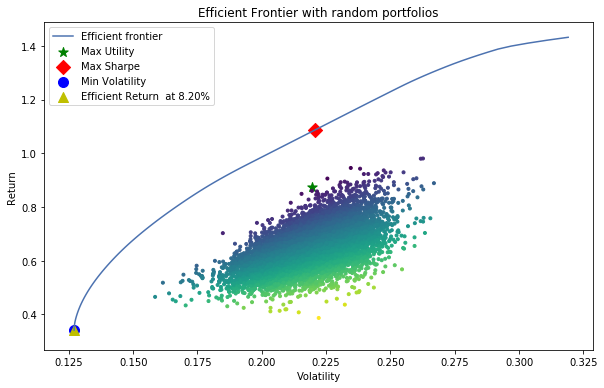

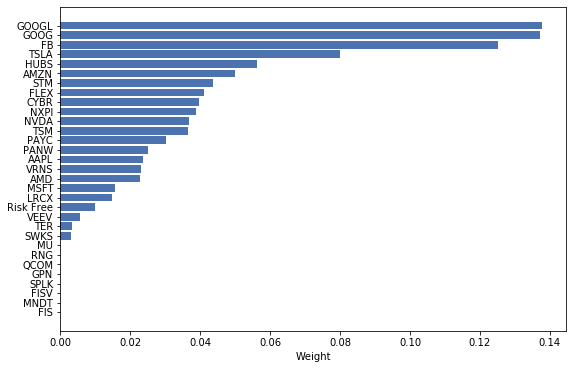

In [63]:
ef_qn2_g_s_ema_bl = po.get_optimal_portfolio(cal_mu=bl_updated.bl_returns(),cal_S= bl_updated.bl_cov(), 
                                         gamma = 10, 
                                          constraint_mapper = [sector_mapper, cap_mapper, region_mapper,growval_mapper, specific_ticker_mapper],
                                          constraint_lower = [sector_lower,cap_lower, region_lower,growval_lower, specific_ticker_lower], 
                                          constraint_upper = [sector_upper,cap_upper, region_upper,growval_upper, specific_ticker_upper], upper_weight_bound = 0.25)

In [64]:
portfolio_to_use = ef_qn2_g_s_ema_bl

In [65]:
portfolio_dict_own_portfolio = {}
for i in range(len(portfolio_to_use.weights)):
    if portfolio_to_use.weights[i] > 0 :
        portfolio_dict_own_portfolio[portfolio_to_use.tickers[i]] = portfolio_to_use.weights[i]

print(portfolio_dict_own_portfolio)

{'AAPL': 0.0236064341245899, 'AMZN': 0.05, 'GOOG': 0.1371188477489712, 'PAYC': 0.030127482057459, 'FB': 0.1251358980213706, 'QCOM': 4.23796749638e-05, 'HUBS': 0.0562056218282164, 'TSM': 0.0365602654591381, 'LRCX': 0.0147339411583731, 'MSFT': 0.0156648121646191, 'AMD': 0.0228684087487891, 'NXPI': 0.0387301106843653, 'GOOGL': 0.1377452542296583, 'PANW': 0.0250186753749726, 'FLEX': 0.0410966254508162, 'NVDA': 0.0367835010470521, 'TER': 0.0033647367915473, 'TSLA': 0.0798909932168779, 'VRNS': 0.0230051990037105, 'STM': 0.0438191666251409, 'SWKS': 0.0030974898106303, 'CYBR': 0.0397938317805395, 'VEEV': 0.0055903249981989, 'Risk Free': 0.01}


# Final Portfolio

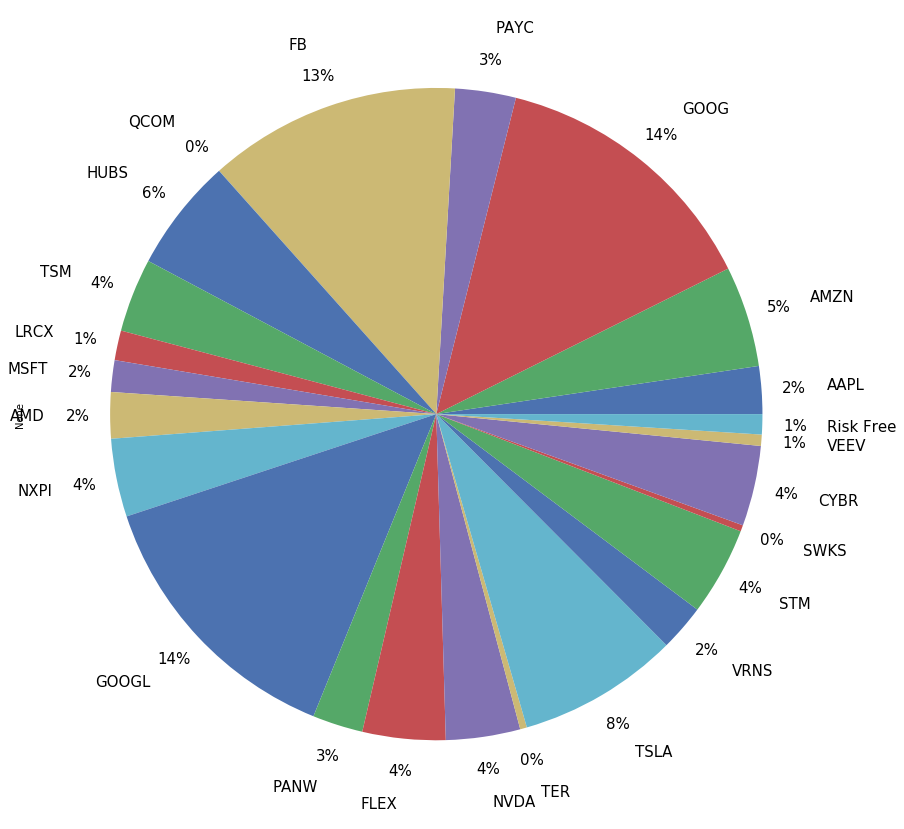

In [66]:
pd.Series(portfolio_dict_own_portfolio).plot.pie(figsize=(15,15),  autopct='%.0f%%', textprops={'fontsize': 15},  pctdistance=1.1, labeldistance=1.2)

# Get portfolio constraint weightage 

In [67]:
from collections import OrderedDict

def get_portfolio_constraint_weightage(weights_dict, mapper_dict):
  result = {}
  for stock, weight in weights_dict.items():
    map = mapper_dict[stock]
    if map == "NIL":
      result["Risk-Free"] = weight
      continue
    if map in result.keys():
      result[map] += weight 
    else: 
      result[map] = weight
  
  return result

def plot_constraint_pie_chart(portfolio_constraint_weightage, title):
    #define data
    portfolio_constraint_weightage_sorted = {k: v for k, v in sorted(portfolio_constraint_weightage.items(), key=lambda item: item[1])}
    data = portfolio_constraint_weightage_sorted.values()
    labels = portfolio_constraint_weightage_sorted.keys()
#     explode = [0.5-i*0.02 for i in range(len(labels))]
    #define Seaborn color palette to use
    colors = sns.color_palette('pastel')[0:5]

    #create pie chart
    plt.figure(figsize=[15, 11])
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', textprops={'fontsize': 15},  pctdistance=0.9, labeldistance=1.2)
    plt.title(title)
    plt.show()

{'United States': 0.79, 'Others': 0.20001, 'Risk-Free': 0.01}


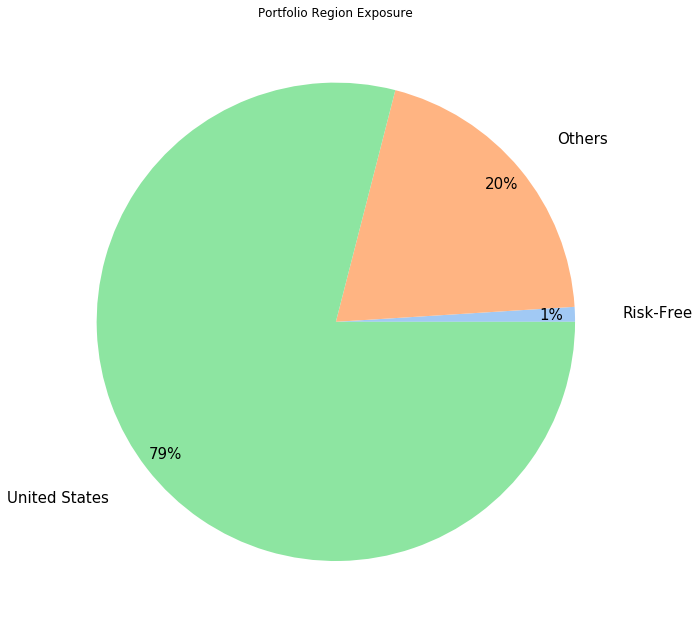

In [68]:
ef_qn2_g_s_ema_weights = ef_qn2_g_s_ema.clean_weights()
# get region weightage 
ef_qn2_g_s_ema_region = get_portfolio_constraint_weightage(ef_qn2_g_s_ema_weights, region_mapper)
print(ef_qn2_g_s_ema_region)

#plot 
plot_constraint_pie_chart(ef_qn2_g_s_ema_region, title = "Portfolio Region Exposure")

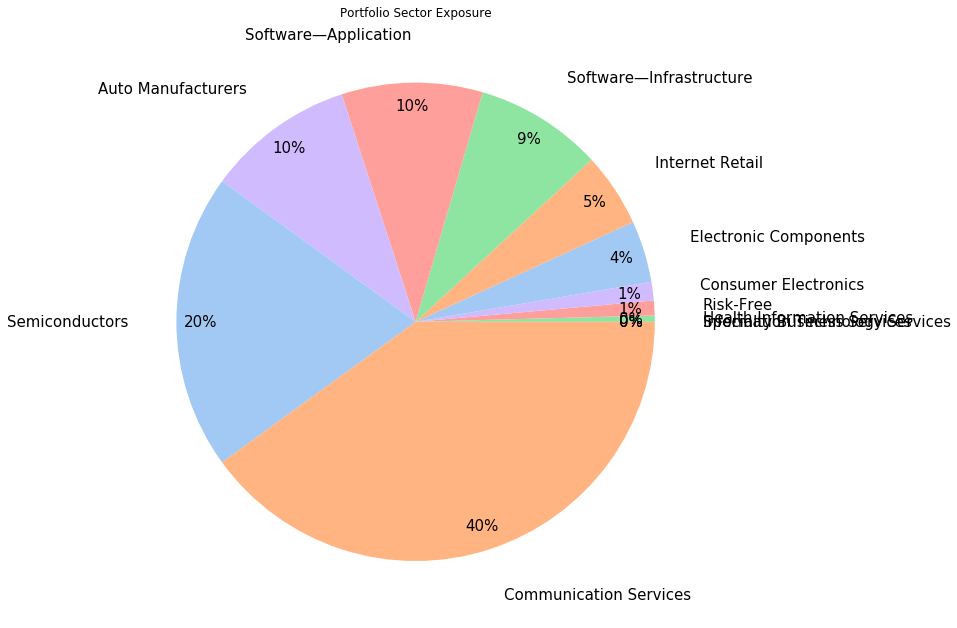

In [69]:
# get sector weightage 
ef_qn2_g_s_ema_sector = get_portfolio_constraint_weightage(ef_qn2_g_s_ema_weights, sector_mapper)
ef_qn2_g_s_ema_sector

#plot 
plot_constraint_pie_chart(ef_qn2_g_s_ema_sector, title = "Portfolio Sector Exposure")

{'Large-cap': 0.8656900000000001, 'Mid-cap': 0.12432, 'Risk-Free': 0.01}


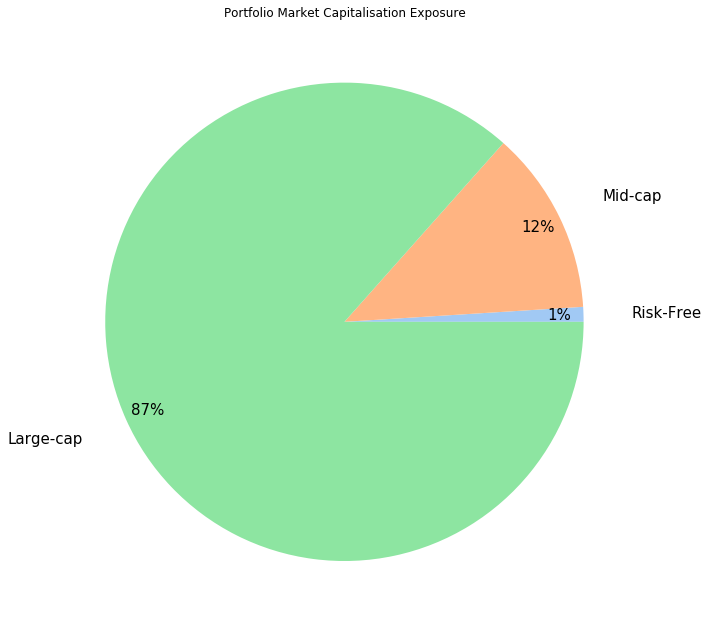

In [70]:
# get cap weightage 
ef_qn2_g_s_ema_cap = get_portfolio_constraint_weightage(ef_qn2_g_s_ema_weights, cap_mapper)
print(ef_qn2_g_s_ema_cap)

#plot 
plot_constraint_pie_chart(ef_qn2_g_s_ema_cap, title = "Portfolio Market Capitalisation Exposure")

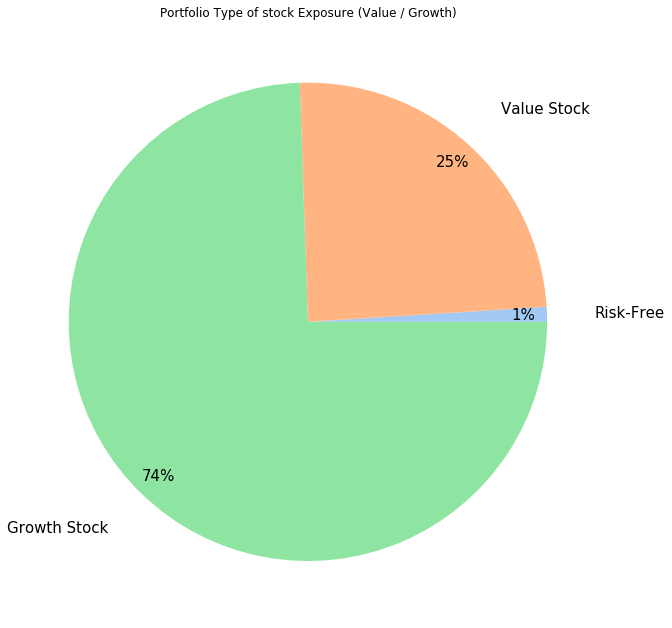

In [71]:
# get type of stocks weightage 
ef_qn2_g_s_ema_growth_or_val = get_portfolio_constraint_weightage(ef_qn2_g_s_ema_weights, growval_mapper)
ef_qn2_g_s_ema_growth_or_val

#plot 
plot_constraint_pie_chart(ef_qn2_g_s_ema_growth_or_val, title = "Portfolio Type of stock Exposure (Value / Growth)")

# Finals Code 

# Question 1

In [72]:
portfolio_dict_best_portfolio_rebased = {'AAPL': 0.1368,
 'AMZN': 0.10859999999999999,
 'GOOG': 0.08130000000000001,
 'PAYC': 0.07730000000000001,
 'FB': 0.0495,
 'MU': 0.0482,
 'RNG': 0.046799999999999994,
 'QCOM': 0.0451,
 'HUBS': 0.040999999999999995,
 'TSM': 0.0341,
 'LRCX': 0.027200000000000002,
 'MSFT': 0.026000000000000002,
 'AMD': 0.0215,
 'NXPI': 0.0212,
 'GOOGL': 0.0206,
 'PANW': 0.0177,
 'FLEX': 0.0171,
 'NVDA': 0.0171,
 'GPN': 0.0166,
 'TER': 0.016200000000000003,
 'TSLA': 0.014499999999999999,
 'SPLK': 0.014199999999999999,
 'FISV': 0.0127,
 'MNDT': 0.011399999999999999,
 'VRNS': 0.011000000000000001,
 'STM': 0.0304,
 'SWKS': 0.0096,
 'FIS': 0.0092,
 'CYBR': 0.0087,
 'VEEV': 0.0085}

In [73]:
portfolio_dict_best_portfolio_rebased_2021 = {'AAPL': 0.1028263288797341,
 'AMZN': 0.09948024976512558,
 'GOOG': 0.14176812410861278,
 'PAYC': 0.07018830364740897,
 'FB': 0.07748572980716593,
 'MU': 0.037614026259929705,
 'RNG': 0.0,
 'QCOM': 0.0,
 'HUBS': 0.11061075859085524,
 'TSM': 0.04572334940229092,
 'LRCX': 0.02564992317171998,
 'MSFT': 0.09168615188550437,
 'AMD': 0.012760118015250767,
 'NXPI': 0.02601983684734098,
 'GOOGL': 0.01736479691799605,
 'PANW': 0.02905071934563468,
 'FLEX': 0.003996851891555444,
 'NVDA': 0.04575477691792138,
 'GPN': 0.0,
 'TER': 0.00840729370833121,
 'TSLA': 0.0026150271182816343,
 'SPLK': 0.0,
 'FISV': 0.008000633830803653,
 'MNDT': 0.0,
 'VRNS': 0.012054936128068391,
 'STM': 0.021095714495747153,
 'SWKS': 0.005485444278697291,
 'FIS': 0.0,
 'CYBR': 0.0,
 'VEEV': 0.004360904986023935}

In [74]:
portfolio_dict_worst_portfolio = {'AAPL': 0.056460346078391295,
 'AEIS': 0.03595126744441367,
 'AMBA': 0.04270720491469772,
 'COHU': 0.04765351915319589,
 'CRM': 0.03522739974321314,
 'CRUS': 0.03619255667814729,
 'CTSH': 0.01664856594728029,
 'CTXS': 0.03462419966948712,
 'DIOD': 0.038364090749925445,
 'FB': 0.031849442513375015,
 'FFIV': 0.028592106889795903,
 'FTNT': 0.03486548890322062,
 'ILMN': 0.03619255667814729,
 'JKHY': 0.027747617582336376,
 'KLAC': 0.041500781756637864,
 'KLIC': 0.03341777651142727,
 'LRCX': 0.04282784953156441,
 'NXGN': 0.03402099959576109,
 'PANW': 0.038364090749925445,
 'PCTY': 0.03136686404590801,
 'PRFT': 0.0314875086627747,
 'QCOM': 0.03486548890322062,
 'SAIC': 0.021353602457348797,
 'SIMO': 0.021353602457348797,
 'SNX': 0.006876582087150722,
 'TCEHY': 0.04898056391751464,
 'TSLA': 0.05404754578348731,
 'UI': 0.03607191206128048,
 'VRNT': 0.020388468533022574}

In [75]:
def get_port_performance(portfolio, allocation_end_date = '2021-01-01', return_start_date='2021-12-31',return_end_date="2021-10-31", total_portfolio_value=5000000000):
    
    allocation_dict = create_allocation_dict(portfolio, end_date = allocation_end_date, total_portfolio_value=total_portfolio_value )
    historical_portfolio_value_df = prepare_data(allocation_dict, start_date=return_start_date,end_date=return_end_date)
    weights =  np.array(list(portfolio.values()))
    
    # YTD
    YTD = round((historical_portfolio_value_df['Portfolio Value'][-1] / historical_portfolio_value_df['Portfolio Value'][0] - 1)* 100,2)
    
    # Vol
    volatility = historical_portfolio_value_df['Portfolio log_return'].std()
    annualised_vol = round(volatility * 252 ** 0.5 * 100, 2)
    
    return YTD , annualised_vol

In [76]:
def remove_0_weights(portfolio):
    portfolio_dict_own_portfolio = {}
    for i in range(len(portfolio.weights)):
        if portfolio.weights[i] > 0 :
            portfolio_dict_own_portfolio[portfolio.tickers[i]] = portfolio.weights[i]
    return portfolio_dict_own_portfolio

# Question 1a: Portfolio Performance

In [77]:
best_mutual_fund = portfolio_dict_best_portfolio
worst_mutal_fund = portfolio_dict_worst_portfolio
portfolio_dec_31 = remove_0_weights(ef_qn2_g_s_ema)
portfolio_sep_31 = remove_0_weights(ef_qn2_g_s_ema_bl)
four_portfolio = [best_mutual_fund, worst_mutal_fund, portfolio_dec_31,portfolio_sep_31]

In [78]:
results_list = []
port_names = ['Best', 'Worst' , 'Port 31 Dec', 'Port 31 Sep']
for port, name in zip(four_portfolio,port_names):
    YTD , annualised_vol = get_port_performance(port, allocation_end_date = '2021-01-01', return_start_date='2020-12-31',return_end_date="2021-10-31",)
    results_list.append([name, YTD , annualised_vol])
    
results = pd.DataFrame(results_list, columns = ['Portfolio', 'YTD %', 'Annualised Vol %'])
results

Allocation was not perfect and you have $0.05 leftover
Amount invested is $4999999999.951493
Allocation was not perfect and you have $10.58 leftover
Amount invested is $4999999989.415655
Allocation was not perfect and you have $7.47 leftover
Amount invested is $4999999992.5270195
Allocation was not perfect and you have $15.41 leftover
Amount invested is $4999999984.586485


,Portfolio,YTD %,Annualised Vol %
0,Best,19.30,21.85
1,Worst,29.46,23.39
2,Port 31 Dec,34.50,22.84
3,Port 31 Sep,42.68,22.68


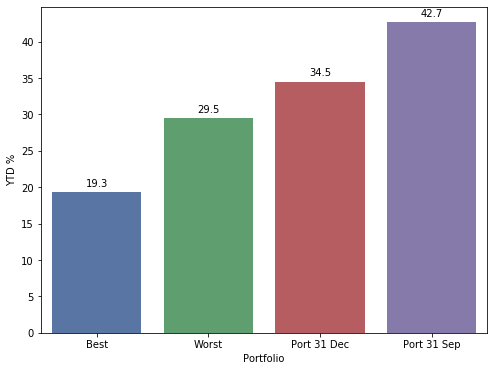

In [79]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x = results.Portfolio, y  = results["YTD %"])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

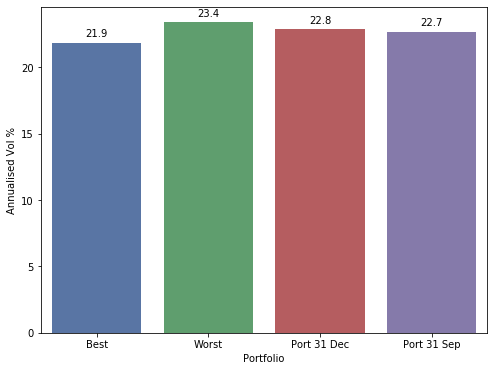

In [80]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x = results.Portfolio, y  = results["Annualised Vol %"])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Question 1b: October Results

In [81]:
results_list_oct = []
for port, name in zip(four_portfolio,port_names):
    YTD , annualised_vol = get_port_performance(port, allocation_end_date = '2021-01-01', return_start_date='2021-10-01',return_end_date="2021-10-31",)
    results_list_oct.append([name, YTD , annualised_vol])
    
results_oct = pd.DataFrame(results_list_oct, columns = ['Portfolio', 'Monthly Return (Oct)', "Annualised Vol %"])
results_oct

Allocation was not perfect and you have $0.05 leftover
Amount invested is $4999999999.951493
Allocation was not perfect and you have $10.58 leftover
Amount invested is $4999999989.415655
Allocation was not perfect and you have $7.47 leftover
Amount invested is $4999999992.5270195
Allocation was not perfect and you have $15.41 leftover
Amount invested is $4999999984.586485


,Portfolio,Monthly Return (Oct),Annualised Vol %
0,Best,6.51,16.83
1,Worst,6.58,18.01
2,Port 31 Dec,9.31,18.57
3,Port 31 Sep,9.54,18.46


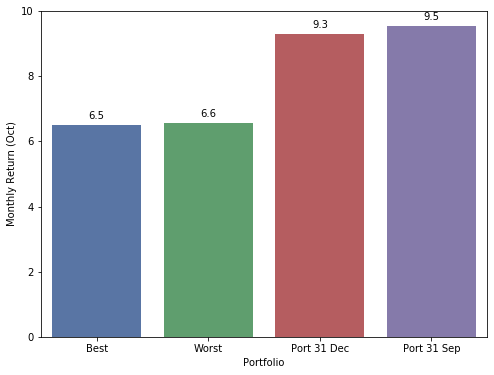

In [82]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x = results_oct.Portfolio, y  = results_oct["Monthly Return (Oct)"])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

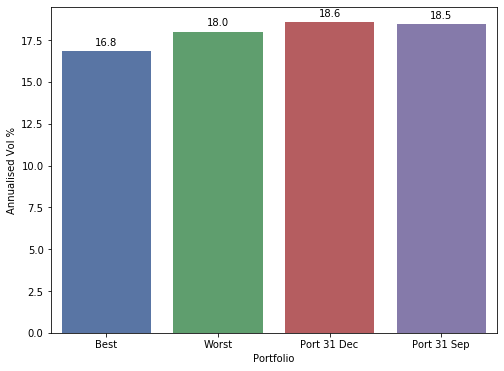

In [83]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x = results_oct.Portfolio, y  = results_oct["Annualised Vol %"])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Question 2: Risk Return of New weights 

In [84]:
best_mutual_fund = portfolio_dict_best_portfolio_rebased
best_mutual_fund_2021 = portfolio_dict_best_portfolio_rebased_2021
worst_mutal_fund = portfolio_dict_worst_portfolio
portfolio_dec_31 = remove_0_weights(ef_qn2_g_s_ema)
portfolio_sep_31 = remove_0_weights(ef_qn2_g_s_ema_bl)
four_portfolio_new_weights = [best_mutual_fund, best_mutual_fund_2021, worst_mutal_fund, portfolio_dec_31,portfolio_sep_31]

In [85]:
results_list_new_weights = []
port_names_new_weights = ['Best (12/20)','Best (10/21)', 'Worst' , 'Port 31 Dec', 'Port 31 Sep']
for port, name in zip(four_portfolio_new_weights,port_names_new_weights):
    YTD , annualised_vol = get_port_performance(port, allocation_end_date = '2021-01-01', return_start_date='2021-01-01',return_end_date="2021-10-31",)
    results_list_new_weights.append([name, YTD , annualised_vol])
    
results_new_weights = pd.DataFrame(results_list_new_weights, columns = ['Portfolio', 'YTD %', 'Annualised Vol %'])
results_new_weights

Allocation was not perfect and you have $2.50 leftover
Amount invested is $4999999997.50108
Allocation was not perfect and you have $34.91 leftover
Amount invested is $4999999965.085205
Allocation was not perfect and you have $10.58 leftover
Amount invested is $4999999989.415655
Allocation was not perfect and you have $7.47 leftover
Amount invested is $4999999992.5270195
Allocation was not perfect and you have $15.41 leftover
Amount invested is $4999999984.586485


,Portfolio,YTD %,Annualised Vol %
0,Best (12/20),22.15,22.16
1,Best (10/21),42.19,22.68
2,Worst,29.88,23.45
3,Port 31 Dec,35.25,22.89
4,Port 31 Sep,43.65,22.73


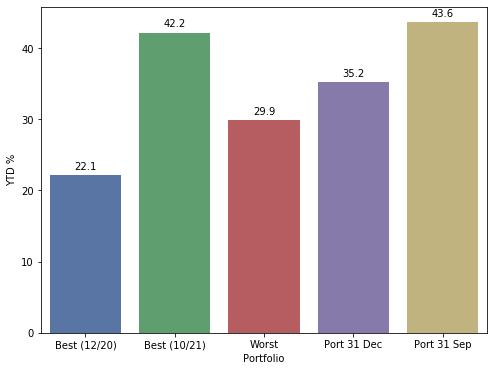

In [86]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x = results_new_weights.Portfolio, y  = results_new_weights["YTD %"])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

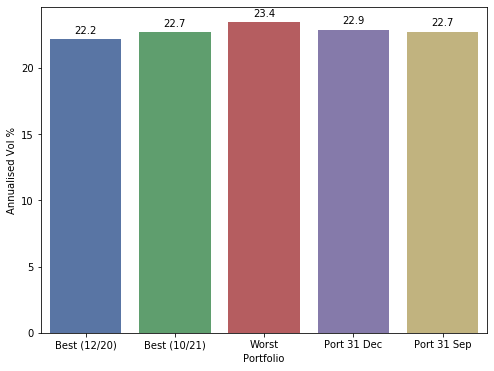

In [87]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x = results_new_weights.Portfolio, y  = results_new_weights["Annualised Vol %"])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Question 3: Hedging by Options 

In [88]:
# import modules 
import pandas as pd 
import numpy as np 
import requests_cache
from pandas_datareader.data import DataReader
import scipy.stats as si
from scipy.stats import norm
import matplotlib.pyplot as plt

In [89]:
def euro_vanilla_call(S, X, T, r, sigma):
    
    # Formula for obtaining price of european call options
    
    #S: current stock price
    #X: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / X) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - X * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return round(call, 3)

def euro_vanilla_put(S, X, T, r, sigma):
    
    # Formula for obtaining price of european put options
    
    #S: current stock price
    #X: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / X) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    
    put = (X * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    
    return round(put, 3)

def bs_call(S, K, T, r, vol):
    return euro_vanilla_call(S, K, T, r, vol)

def bs_put(S, K, T, r, vol):
    return euro_vanilla_put(S, K, T, r, vol)


def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol_call(target_value, S, K, T, r, *args):
    #NOTE: THIS IS FOR A CALL IV computation only, for put refer to the other computation
    # to find the implied volaility using the BSM
    # need to use trial and error
    
    MAX_ITERATIONS = 1500
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far


def find_vol_put(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 500
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_put(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

def put_profit_loss(sT, strike_price, premium):
    return np.where(sT < strike_price, strike_price - sT, 0) - premium 

def call_profit_loss(sT, strike_price, premium):
    return np.where(sT > strike_price, sT - strike_price, 0) - premium


def get_price_data_for_multiple_stocks(tickers, start_date, end_date):

    session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

    # just add headers to your session and provide it to the reader
    session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                    'Accept': 'application/json;charset=utf-8'}

    # initialise output dataframe
    prices_df = pd.DataFrame()

    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        if ticker != 'Risk Free':
            s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)

            prices_df[ticker] = s['Adj Close']

    if (prices_df.isnull().sum().sum() != 0):
        print(f'There are prices that are NA in this dataframe')

    return prices_df

def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Function that uses Pandas DataReader to download data directly from Yahoo Finance,
    computes the Log Returns series for each ticker, and returns a DataFrame 
    containing the Log Returns of all specified tickers. 

    Parameters:
    - tickers (list): List of Stock Tickers.
    - start_date, end_date (str): Start and end dates in the format 'YYYY-MM-DD'.

    Returns:
    - returns_df (pd.DataFrame): A DataFrame with dates as indexes, and columns corresponding
                                to the log returns series of each ticker.
    '''
    session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

    # just add headers to your session and provide it to the reader
    session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                    'Accept': 'application/json;charset=utf-8'}
    # initialise output dataframe
    returns_df = pd.DataFrame()

    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
        # calculate log returns
        s['Log Returns'] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
        # append to returns_df
        returns_df[ticker] = s['Log Returns']

    return returns_df

def stock_profit_loss(sT, purchase_price):
    return np.where(sT >= 0, sT - purchase_price, 0) 

In [90]:
# TSLA closing price on 20-10-2021 
TSLA_price_20_10_2021 = 865.80
# FB closing price on 20-10-2021
FB_price_20_10_2021 = 340.78

In [91]:
# reading option data 
TSLA_call = pd.read_csv("TSLA_CALL_05_11.csv")
TSLA_put = pd.read_csv("./TSLA_PUT_05_11.csv")
FB_put = pd.read_csv("./FB_PUT_05_11.csv")

In [92]:
TSLA_call.head()

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
0,0,50,2021-11-05 00:00:00,call,TSLA211105C00050000,819.10,0,0,0,0,3.0,0,0.00001,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-19 19:01:50,"{'contractSymbol': 'TSLA211105C00050000', 'str..."
1,1,100,2021-11-05 00:00:00,call,TSLA211105C00100000,718.05,0,0,0,0,5.0,0,0.00001,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-14 16:14:10,"{'contractSymbol': 'TSLA211105C00100000', 'str..."
2,2,150,2021-11-05 00:00:00,call,TSLA211105C00150000,716.00,0,0,0,0,1.0,0,0.00001,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 17:45:22,"{'contractSymbol': 'TSLA211105C00150000', 'str..."
3,3,250,2021-11-05 00:00:00,call,TSLA211105C00250000,532.20,0,0,0,0,NaN,0,0.00001,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-09-30 14:33:04,"{'contractSymbol': 'TSLA211105C00250000', 'str..."
4,4,300,2021-11-05 00:00:00,call,TSLA211105C00300000,510.95,0,0,0,0,NaN,0,0.00001,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-12 18:16:13,"{'contractSymbol': 'TSLA211105C00300000', 'str..."


# Protective Put for FB

## Finding Implied volatility using Black Scholas Model 

In [93]:
# finding option with exercise closest to FB close price
FB_put.iloc[(FB_put['Strike']-FB_price_20_10_2021).abs().argsort()[:2]]

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
35,35,340,2021-11-05 00:00:00,put,FB211105P00340000,10.95,0,0,0,0,76.0,0,0.003916,FB,False,FB,339.78,2021-10-21 08:28:29,2021-10-20 19:48:59,"{'contractSymbol': 'FB211105P00340000', 'strik..."
36,36,345,2021-11-05 00:00:00,put,FB211105P00345000,13.30,0,0,0,0,4.0,0,0.000010,FB,False,FB,339.78,2021-10-21 08:28:29,2021-10-20 18:21:59,"{'contractSymbol': 'FB211105P00345000', 'strik..."


In [94]:
# buy the option with 340 close price 
FB_put_at_the_money = FB_put[FB_put["Strike"] == 340]

# implied volatility using Black Scholes model
FB_put_at_the_money_option_price = float(FB_put_at_the_money["Last"])
FB_put_IV = find_vol_put(target_value = FB_put_at_the_money_option_price, S=FB_price_20_10_2021 , K =340 , T = 16/365, r=0.01)

print(f"FB put option's Implied volatility at the money on 20-10-2021: {FB_put_IV}")

FB put option's Implied volatility at the money on 20-10-2021: 0.40146856533581937


## Finding exercise price for put option 

In [95]:
# buying one put option at exercise price = stock price - one standard deviation
FB_1_sd_put = FB_price_20_10_2021 * FB_put_IV  * np.sqrt(16/365)
FB_put_exercise_price = FB_price_20_10_2021  - FB_1_sd_put
print(f"FB 1 S.D for put: {FB_1_sd_put}")
print(f"Buying a FB put option with exercise price: {FB_put_exercise_price}")

FB 1 S.D for put: 28.644365306399248
Buying a FB put option with exercise price: 312.1356346936007


In [96]:
# finding the put option closest to the calculated exercise 
FB_put.iloc[(FB_put['Strike']-FB_put_exercise_price).abs().argsort()[:2]]

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
29,29,310,2021-11-05 00:00:00,put,FB211105P00310000,2.17,0,0,0,0,84.0,0,0.125009,FB,False,FB,339.78,2021-10-21 08:28:29,2021-10-20 19:56:47,"{'contractSymbol': 'FB211105P00310000', 'strik..."
30,30,315,2021-11-05 00:00:00,put,FB211105P00315000,2.92,0,0,0,0,96.0,0,0.062509,FB,False,FB,339.78,2021-10-21 08:28:29,2021-10-20 19:45:15,"{'contractSymbol': 'FB211105P00315000', 'strik..."


In [97]:
# we buy the option with exercise price = 310 
buy_FB_put = FB_put[FB_put["Strike"] == 310]
FB_put_premium = float(buy_FB_put["Last"])

## Plot for value of 1 put option 

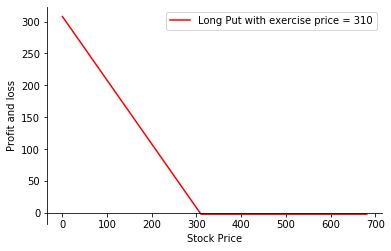

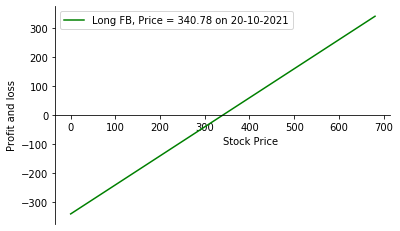

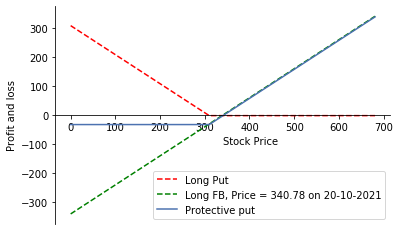

In [98]:
FB_sT = np.arange(0,2*FB_price_20_10_2021,1) 
profit_loss_long_put = put_profit_loss(FB_sT, 310, FB_put_premium)
# Plot long put 
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center
ax.plot(FB_sT,profit_loss_long_put,label='Long Put with exercise price = 310',color='r')
plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

# plot long FB stock 
profit_loss_long_stock = stock_profit_loss(FB_sT, FB_price_20_10_2021)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center
ax.plot(FB_sT,profit_loss_long_stock,label=f'Long FB, Price = {FB_price_20_10_2021} on 20-10-2021',color='g')
plt.xlabel('Stock Price', ha='left')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

# plot protective put (long put + long stock )
profit_loss_covered_call = profit_loss_long_put + profit_loss_long_stock
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center

ax.plot(FB_sT,profit_loss_long_put ,'--',label='Long Put',color='r')
ax.plot(FB_sT,profit_loss_long_stock,'--',label=f'Long FB, Price = {FB_price_20_10_2021} on 20-10-2021',color='g')

ax.plot(FB_sT,profit_loss_covered_call,label='Protective put')
plt.xlabel('Stock Price', ha='left')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()


## Profit of Protective put 

In [99]:
FB_price_05_11_2021 = 341.13 # replace with 05-11-2021 closing price 
# Find out how many FB Stock we brought in 31-12-2020
FB_weight = 0.0495
# FB Price at 31-12-2020
FB_price_31_12_2020 = 273.16
# finding the number of stocks brought for FB on 31-12-2020
AUM = 5000000000
FB_weight_cash = FB_weight * AUM
FB_stock_brought = round(FB_weight_cash / FB_price_31_12_2020)
print(f"No. of FB Stocks brought on 31-12-2020: {FB_stock_brought}\n")

# total FB value on 20-10-2021
FB_portfolio_20_10_2021 = FB_stock_brought * FB_price_20_10_2021
print(f"FB stock price on 20-10-2021: {FB_price_20_10_2021}")
print(f"Total value of FB stock on 20-10-2021: {FB_portfolio_20_10_2021}\n")

# total FB value on 05-11-2021
FB_portfolio_05_11_2021 = FB_stock_brought * FB_price_05_11_2021
print(f"FB stock price on 05-11-2021: {FB_price_05_11_2021}")
print(f"Total value of FB stock on 05-11-2021: {FB_portfolio_05_11_2021}\n")

# Calculate profit for 1 FB put  
FB_option_profit_loss_long_put = put_profit_loss(FB_price_05_11_2021, 310, FB_put_premium)
print(f"Profit/loss of 1 FB long put with exercise price = 310 : {FB_option_profit_loss_long_put}")
total_FB_option_profit_loss_long_put = FB_option_profit_loss_long_put * FB_stock_brought
print(f"Total profit/loss of put option: ${total_FB_option_profit_loss_long_put}\n")

# profit/loss of 1 FB stock 
FB_stock_profit_loss = FB_price_05_11_2021 - FB_price_20_10_2021
print(f"Profit/loss of 1 FB stock: ${FB_stock_profit_loss}, {FB_stock_profit_loss / FB_price_20_10_2021}%")

# profit/loss of 1 FB stock + 1 long put 
FB_stock_profit_loss_with_put = FB_stock_profit_loss + FB_option_profit_loss_long_put
print(f"Profit/loss of 1 FB stock with protective put: ${FB_stock_profit_loss_with_put}, {FB_stock_profit_loss_with_put / FB_price_20_10_2021}%\n")

# total profit/loss without protective put 
FB_total_without_put = FB_portfolio_05_11_2021 - FB_portfolio_20_10_2021
print(f"Total FB profit/loss from 20-10-2021 to 05-11-2021 (Without protective put): {FB_total_without_put}")

# total profit/loss with protective put 
FB_total_with_put = FB_portfolio_05_11_2021 - FB_portfolio_20_10_2021 + total_FB_option_profit_loss_long_put
print(f"Total FB profit/loss from 20-10-2021 to 05-11-2021 (With protective put): {FB_total_with_put}")

# differences 
print(f"Differences: {FB_total_with_put - FB_total_without_put}")

No. of FB Stocks brought on 31-12-2020: 906062

FB stock price on 20-10-2021: 340.78
Total value of FB stock on 20-10-2021: 308767808.35999995

FB stock price on 05-11-2021: 341.13
Total value of FB stock on 05-11-2021: 309084930.06

Profit/loss of 1 FB long put with exercise price = 310 : -2.17
Total profit/loss of put option: $-1966154.54

Profit/loss of 1 FB stock: $0.35000000000002274, 0.0010270555783790797%
Profit/loss of 1 FB stock with protective put: $-1.8199999999999772, -0.0053406890075708%

Total FB profit/loss from 20-10-2021 to 05-11-2021 (Without protective put): 317121.7000000477
Total FB profit/loss from 20-10-2021 to 05-11-2021 (With protective put): -1649032.8399999524
Differences: -1966154.54


# Straddle for TSLA

## Finding Implied volatility using Black Scholes Model

In [100]:
# TSLA closing price on 20-10-2021 
TSLA_price_20_10_2021 = 865.80

In [101]:
# finding option with exercise closest to TSLA close price
TSLA_call.iloc[(TSLA_call['Strike']-TSLA_price_20_10_2021).abs().argsort()[:2]]

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
74,74,865,2021-11-05 00:00:00,call,TSLA211105C00865000,28.10,0,0,0,0,1763.0,0,0.000010,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 19:59:42,"{'contractSymbol': 'TSLA211105C00865000', 'str..."
75,75,870,2021-11-05 00:00:00,call,TSLA211105C00870000,25.36,0,0,0,0,810.0,0,0.007822,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 19:59:50,"{'contractSymbol': 'TSLA211105C00870000', 'str..."


In [102]:
# finding option with exercise closest to TSLA close price
TSLA_put.iloc[(TSLA_put['Strike']-TSLA_price_20_10_2021).abs().argsort()[:2]]

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
84,84,865,2021-11-05 00:00:00,put,TSLA211105P00865000,28.25,0,0,0,0,276.0,0,0.000987,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 19:59:18,"{'contractSymbol': 'TSLA211105P00865000', 'str..."
85,85,870,2021-11-05 00:00:00,put,TSLA211105P00870000,30.38,0,0,0,0,551.0,0,0.000010,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 19:59:20,"{'contractSymbol': 'TSLA211105P00870000', 'str..."


In [103]:
# buy option at exercise price = 865
# implied volatility for TSLA call for option at the money 
TSLA_call_at_the_money = TSLA_call[TSLA_call["Strike"] == 865]
TSLA_call_at_the_money_option_price = float(TSLA_call_at_the_money["Last"])
TSLA_call_IV = find_vol_call(target_value = TSLA_call_at_the_money_option_price, S=TSLA_price_20_10_2021 , K =865 , T = 16/365, r=0.01)

#implied volatility for TSLA put for option at the money 
TSLA_put_at_the_money = TSLA_put[TSLA_put["Strike"] == 865]
TSLA_put_at_the_money_option_price = float(TSLA_put_at_the_money["Last"])
TSLA_put_IV = find_vol_put(target_value = TSLA_put_at_the_money_option_price, S=TSLA_price_20_10_2021 , K =865 , T = 16/365, r=0.01)

print(f"TSLA call option's Implied volatility at the money on 20-10-2021: {TSLA_call_IV}")
print(f"TSLA put option's Implied volatility at the money on 20-10-2021: {TSLA_put_IV}")

TSLA call option's Implied volatility at the money on 20-10-2021: 0.38071419876021606
TSLA put option's Implied volatility at the money on 20-10-2021: 0.39913088399834595


In [104]:
# double checking if the Implied Volatility is able to get the same option price 
print(f"Actual call option price: {TSLA_call_at_the_money_option_price}")
print(f"Call Option price using Implied Volatility: {bs_call(TSLA_price_20_10_2021, 865,16/365,0.01,TSLA_call_IV)}")

print(f"Actual put option price: {TSLA_put_at_the_money_option_price}")
print(f"Put Option price using Implied Volatility: {bs_put(TSLA_price_20_10_2021, 865,16/365,0.01,TSLA_put_IV)}")

Actual call option price: 28.1
Call Option price using Implied Volatility: 28.1
Actual put option price: 28.25
Put Option price using Implied Volatility: 28.25


## Finding exercise price for call and put option

Reference: https://www.tastytrade.com/definitions/standard-deviation

In [105]:
# buying one call option at exercise price = stock price + one standard deviation
TSLA_1_sd_call = TSLA_price_20_10_2021 * TSLA_call_IV  * np.sqrt(16/365)  
TSLA_call_exercise_price = TSLA_price_20_10_2021  + TSLA_1_sd_call
# buying one put option at exercise price = stock price - one standard deviation
TSLA_1_sd_put = TSLA_price_20_10_2021 * TSLA_put_IV  * np.sqrt(16/365)
TSLA_put_exercise_price = TSLA_price_20_10_2021  - TSLA_1_sd_put

print(f"TSLA 1 S.D for call: {TSLA_1_sd_call}")
print(f"Buying a TSLA call option with exercise price: {TSLA_call_exercise_price}")
print(f"TSLA 1 S.D for put: {TSLA_1_sd_put}")
print(f"Buying a TSLA put option with exercise price: {TSLA_put_exercise_price}")

TSLA 1 S.D for call: 69.01289005227471
Buying a TSLA call option with exercise price: 934.8128900522747
TSLA 1 S.D for put: 72.35132260247995
Buying a TSLA put option with exercise price: 793.44867739752


In [106]:
# finding the top 2 call option that are closest to the calculated price # which one to buy ?
TSLA_call.iloc[(TSLA_call['Strike']-TSLA_call_exercise_price).abs().argsort()[:2]]

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
82,82,930,2021-11-05 00:00:00,call,TSLA211105C00930000,6.86,0,0,0,0,139.0,0,0.062509,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 19:59:47,"{'contractSymbol': 'TSLA211105C00930000', 'str..."
83,83,940,2021-11-05 00:00:00,call,TSLA211105C00940000,5.60,0,0,0,0,158.0,0,0.062509,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 19:59:43,"{'contractSymbol': 'TSLA211105C00940000', 'str..."


In [107]:
# finding the top 2 put option that are closest to the calculated price 
TSLA_put.iloc[(TSLA_put['Strike']-TSLA_put_exercise_price).abs().argsort()[:2]]

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
70,70,795,2021-11-05 00:00:00,put,TSLA211105P00795000,10.15,0,0,0,0,259.0,0,0.062509,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 19:57:19,"{'contractSymbol': 'TSLA211105P00795000', 'str..."
69,69,790,2021-11-05 00:00:00,put,TSLA211105P00790000,9.75,0,0,0,0,156.0,0,0.062509,TSLA,False,TSLA,858,2021-10-21 08:29:04,2021-10-20 19:59:53,"{'contractSymbol': 'TSLA211105P00790000', 'str..."


In [108]:
# buy call option with strike price = 930
buy_TSLA_call = TSLA_call[TSLA_call["Strike"] == 930]
TSLA_call_premium = float(buy_TSLA_call["Last"])

# buy put option with strike price = 795 
buy_TSLA_put = TSLA_put[TSLA_put["Strike"] == 795]
TSLA_put_premium = float(buy_TSLA_put["Last"])

## Plot value of 1 straddle 

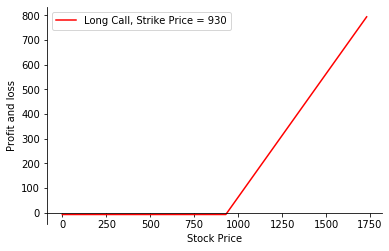

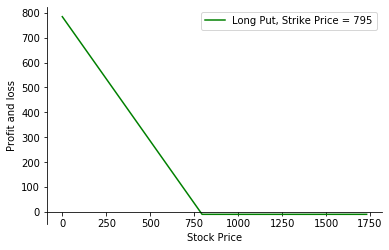

Max Profit of Straddle: Unlimited
Max Loss: -17.01


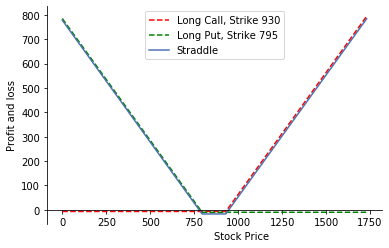

In [109]:
TSLA_sT = np.arange(0,2*TSLA_price_20_10_2021,1) 

profit_loss_long_call = call_profit_loss(TSLA_sT, 930, TSLA_call_premium)
# Plot long call 
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center
ax.plot(TSLA_sT,profit_loss_long_call,label='Long Call, Strike Price = 930',color='r')
plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

profit_loss_long_put = put_profit_loss(TSLA_sT, 795, TSLA_put_premium)
# Plot long put 
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center
ax.plot(TSLA_sT,profit_loss_long_put,label='Long Put, Strike Price = 795',color='g')
plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

# plot straddle 
profit_loss_straddle = profit_loss_long_call + profit_loss_long_put

print ("Max Profit of Straddle: Unlimited")
print ("Max Loss:", min(profit_loss_straddle))
# Plot
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center

ax.plot(TSLA_sT,profit_loss_long_call,'--',label='Long Call, Strike 930',color='r')
ax.plot(TSLA_sT,profit_loss_long_put,'--',label='Long Put, Strike 795',color='g')

ax.plot(TSLA_sT,profit_loss_straddle,label='Straddle')
plt.xlabel('Stock Price', ha='left')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

## Profit of Straddle 

In [110]:
TSLA_price_05_11_2021 = 1222.09 # replace with 05-11-2021 closing price 
# Find out how many TSLA Stock we brought in 31-12-2020
TSLA_weight = 0.0145
# TSLA Price at 31-12-2020
TSLA_price_31_12_2020 = 705.67
# finding the number of stocks brought for TSLA on 31-12-2020
AUM = 5000000000
TSLA_weight_cash = TSLA_weight * AUM
TSLA_stock_brought = round(TSLA_weight_cash / TSLA_price_31_12_2020)
print(f"No. of TSLA Stocks brought on 31-12-2020: {TSLA_stock_brought}\n")

# total TSLA value on 20-10-2021
TSLA_portfolio_20_10_2021 = TSLA_stock_brought * TSLA_price_20_10_2021
print(f"TSLA stock price on 20-10-2021: {TSLA_price_20_10_2021}")
print(f"Total value of TSLA stock on 20-10-2021: {TSLA_portfolio_20_10_2021}\n")

# total TSLA value on 05-11-2021
TSLA_portfolio_05_11_2021 = TSLA_stock_brought * TSLA_price_05_11_2021
print(f"TSLA stock price on 05-11-2021: {TSLA_price_05_11_2021}")
print(f"Total value of TSLA stock on 05-11-2021: {TSLA_portfolio_05_11_2021}\n")

# Calculate profit for 1 TSLA call
TSLA_option_profit_loss_long_call = call_profit_loss(TSLA_price_05_11_2021, 930, TSLA_put_premium)
print(f"Profit/loss of 1 TSLA long call with exercise price = 930 : {TSLA_option_profit_loss_long_call}")
# Calculate profit for 1 TSLA put  
TSLA_option_profit_loss_long_put = put_profit_loss(TSLA_price_05_11_2021, 795, TSLA_put_premium)
print(f"Profit/loss of 1 TSLA long put with exercise price = 795 : {TSLA_option_profit_loss_long_put}")
# Calculate profit for 1 TSLA straddle 
TSLA_option_profit_loss_straddle = TSLA_option_profit_loss_long_call + TSLA_option_profit_loss_long_put
print(f"Profit/loss of 1 TSLA straddle : {TSLA_option_profit_loss_straddle}")
# Calculate total profit for TSLA Straddle 
TSLA_total_profit_loss_straddle = TSLA_option_profit_loss_straddle * TSLA_stock_brought
print(f"Total Profit/loss of TSLA straddle : {TSLA_total_profit_loss_straddle}\n")

# profit/loss of 1 TSLA stock 
TSLA_stock_profit_loss = TSLA_price_05_11_2021 - TSLA_price_20_10_2021
print(f"Profit/loss of 1 TSLA stock: ${TSLA_stock_profit_loss}, {TSLA_stock_profit_loss / TSLA_price_20_10_2021}%")

# profit/loss of 1 TSLA stock + 1 straddle
TSLA_stock_profit_loss_with_put = TSLA_stock_profit_loss + TSLA_option_profit_loss_straddle
print(f"Profit/loss of 1 TSLA stock with 1 straddle: ${TSLA_stock_profit_loss_with_put}, {TSLA_stock_profit_loss_with_put / TSLA_price_20_10_2021}%\n")


# total profit/loss without straddle
TSLA_total_without_straddle = TSLA_portfolio_05_11_2021 - TSLA_portfolio_20_10_2021
print(f"Total TSLA profit/loss from 20-10-2021 to 05-11-2021 (Without straddle): {TSLA_total_without_straddle}")

# total profit/loss without straddle 
TSLA_total_with_straddle = TSLA_portfolio_05_11_2021 - TSLA_portfolio_20_10_2021 + TSLA_total_profit_loss_straddle
print(f"Total TSLA profit/loss from 20-10-2021 to 05-11-2021 (With straddle): {TSLA_total_with_straddle}")

# differences 
print(f"Differences: {TSLA_total_with_straddle - TSLA_total_without_straddle}\n")

No. of TSLA Stocks brought on 31-12-2020: 102739

TSLA stock price on 20-10-2021: 865.8
Total value of TSLA stock on 20-10-2021: 88951426.19999999

TSLA stock price on 05-11-2021: 1222.09
Total value of TSLA stock on 05-11-2021: 125556304.50999999

Profit/loss of 1 TSLA long call with exercise price = 930 : 281.93999999999994
Profit/loss of 1 TSLA long put with exercise price = 795 : -10.15
Profit/loss of 1 TSLA straddle : 271.78999999999996
Total Profit/loss of TSLA straddle : 27923432.809999995

Profit/loss of 1 TSLA stock: $356.28999999999996, 0.4115153615153615%
Profit/loss of 1 TSLA stock with 1 straddle: $628.0799999999999, 0.7254331254331254%

Total TSLA profit/loss from 20-10-2021 to 05-11-2021 (Without straddle): 36604878.31
Total TSLA profit/loss from 20-10-2021 to 05-11-2021 (With straddle): 64528311.12
Differences: 27923432.809999995



# Question 3 Part 2 

In [111]:
tickers = ['AAPL','AMZN','GOOG','PAYC','FB','MU','RNG','QCOM','HUBS','TSM','LRCX','MSFT','AMD','NXPI','GOOGL','PANW','FLEX','NVDA','GPN','TER','TSLA','SPLK','FISV','MNDT','VRNS','STM','SWKS','FIS','CYBR','VEEV']

In [112]:
start_date = "2021-10-20"
end_date = "2021-11-05" # change to 05-11-2021
stocks_prices = get_price_data_for_multiple_stocks(tickers, start_date = start_date, end_date=end_date)
stock_prices = stocks_prices[1:] # drop first row cause it shows 19-10 price 
stock_prices

,AAPL,AMZN,GOOG,PAYC,FB,MU,RNG,QCOM,HUBS,TSM,LRCX,MSFT,AMD,NXPI,GOOGL,PANW,FLEX,NVDA,GPN,TER,TSLA,SPLK,FISV,MNDT,VRNS,STM,SWKS,FIS,CYBR,VEEV
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-20,149.042480,3415.060059,2848.300049,512.630005,340.779999,68.269997,241.460007,132.160004,795.390015,115.589996,565.500000,307.410004,116.389999,197.520004,2835.379883,511.920013,18.809999,221.029999,161.309998,116.949997,865.799988,167.270004,110.110001,18.120001,63.459999,42.810001,165.639999,124.620003,179.330002,320.000000
2021-10-21,149.262146,3435.010010,2855.610107,533.929993,341.880005,68.639999,248.139999,133.050003,802.479980,116.290001,555.419983,310.760010,119.330002,201.250000,2837.719971,508.000000,18.959999,226.919998,159.990005,117.540001,894.000000,168.830002,110.160004,17.990000,64.410004,43.880001,166.970001,124.430000,183.899994,325.250000
2021-10-22,148.473312,3335.550049,2772.500000,535.820007,324.609985,67.510002,248.039993,131.619995,814.159973,114.230003,556.739990,309.160004,119.820000,199.929993,2751.330078,504.130005,18.670000,227.259995,158.000000,116.120003,909.679993,167.470001,110.180000,17.860001,63.220001,43.900002,165.119995,125.040001,183.750000,320.559998
2021-10-25,148.423386,3320.370117,2775.459961,538.929993,328.690002,68.760002,244.690002,131.929993,805.700012,113.639999,551.969971,308.130005,122.360001,200.289993,2748.939941,497.769989,18.940001,231.660004,157.779999,117.279999,1024.859985,168.360001,111.110001,17.790001,65.980003,44.509998,165.179993,122.440002,182.429993,321.649994
2021-10-26,149.102402,3376.070068,2793.439941,537.190002,315.809998,68.940002,241.789993,131.940002,805.239990,114.180000,548.940002,310.109985,122.930000,196.149994,2786.169922,486.549988,18.719999,247.169998,155.970001,115.150002,1018.429993,167.380005,109.839996,17.600000,65.680000,44.750000,164.330002,122.400002,179.089996,322.989990
2021-10-27,148.633087,3392.489990,2928.550049,531.330017,312.220001,68.239998,237.080002,131.199997,796.950012,113.750000,553.619995,323.170013,122.279999,192.410004,2924.350098,492.859985,18.280001,244.509995,144.130005,123.070000,1037.859985,163.250000,98.830002,17.280001,64.389999,45.029999,165.899994,114.209999,176.610001,313.459991
2021-10-28,152.347656,3446.570068,2922.580078,537.320007,316.920013,69.580002,243.860001,133.690002,814.349976,116.010002,565.950012,324.350006,121.160004,199.899994,2916.979980,498.390015,17.139999,249.410004,142.839996,137.009995,1077.040039,164.500000,98.529999,17.510000,64.790001,48.509998,169.839996,111.900002,177.639999,314.260010
2021-10-29,149.581696,3372.429932,2965.409912,547.849976,323.570007,69.099998,243.779999,133.039993,810.229980,113.699997,563.570007,331.619995,120.230003,200.860001,2960.919922,509.089996,16.900000,255.669998,142.990005,138.240005,1114.000000,164.820007,98.489998,17.440001,64.739998,47.639999,167.130005,110.739998,180.110001,317.010010
2021-11-01,148.742920,3318.110107,2875.479980,546.580017,329.980011,70.699997,252.389999,134.809998,803.669983,114.120003,572.760010,329.369995,125.230003,205.130005,2869.939941,508.309998,17.660000,258.269989,145.820007,139.610001,1208.589966,166.000000,101.989998,17.930000,66.199997,47.720001,169.800003,114.000000,180.630005,314.809998


# Worst performing stock 

## Finding the worst performing stock 

In [113]:
# get the returns for each stocks 
prices_on_start_date = stocks_prices.loc[start_date]
prices_on_end_date = stocks_prices.loc[end_date]

prices_differences = prices_on_end_date - prices_on_start_date
stocks_returns = prices_differences / prices_on_start_date
worst_performing_stock = stocks_returns.idxmin()
print(f"Worst performing stock from {start_date} to {end_date}: {worst_performing_stock}, returns: {stocks_returns.min()}")

Worst performing stock from 2021-10-20 to 2021-11-05: GPN, returns: -0.15225341225160363


In [114]:
# to be change on 5-11-2021
worst_stock_price_20_10_21 = 161.31
worst_stock_price_05_11_21 = 136.75
worst_put = pd.read_csv("./GPN_PUT_05_11.csv")

## Finding IV using Black Scholas Model 

In [115]:
# finding option with exercise closest to close price
worst_put.iloc[(worst_put['Strike']-worst_stock_price_20_10_21).abs().argsort()[:2]]

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
14,14,160,2021-11-19 00:00:00,put,GPN211119P00160000,4.7,0.0,0.0,0,0,73.0,0,0.007822,GPN,False,GPN,161.31,2021-10-20 20:00:02,2021-10-20 18:09:00,"{'contractSymbol': 'GPN211119P00160000', 'stri..."
15,15,165,2021-11-19 00:00:00,put,GPN211119P00165000,7.1,0.0,0.0,0,0,43.0,0,0.000010,GPN,False,GPN,161.31,2021-10-20 20:00:02,2021-10-20 18:55:07,"{'contractSymbol': 'GPN211119P00165000', 'stri..."


In [116]:
# buy the option with 160 close price 
worst_put_at_the_money = worst_put[worst_put["Strike"] == 160]

# implied volatility using Black Scholes model
worst_put_at_the_money_option_price = float(worst_put_at_the_money["Last"])
worst_put_IV = find_vol_put(target_value = worst_put_at_the_money_option_price, S=worst_stock_price_20_10_21 , K =160 , T = 16/365, r=0.01)

print(f"worst put option's Implied volatility at the money on 20-10-2021: {worst_put_IV}")

worst put option's Implied volatility at the money on 20-10-2021: 0.3997936217591249


## Finding exercise price for put option 

In [117]:
# buying one put option at exercise price = stock price - one standard deviation
worst_1_sd_put = worst_stock_price_20_10_21 * worst_put_IV  * np.sqrt(16/365)
worst_put_exercise_price = worst_stock_price_20_10_21  - worst_1_sd_put
print(f"worst 1 S.D for put: {worst_1_sd_put}")
print(f"Buying a worst put option with exercise price: {worst_put_exercise_price}")

worst 1 S.D for put: 13.50239197653472
Buying a worst put option with exercise price: 147.8076080234653


In [118]:
# finding the put option closest to the calculated exercise 
worst_put.iloc[(worst_put['Strike']-worst_put_exercise_price).abs().argsort()[:2]]

,Unnamed: 0,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
12,12,150,2021-11-19 00:00:00,put,GPN211119P00150000,1.85,0.0,0.0,0,0,7.0,0,0.062509,GPN,False,GPN,161.31,2021-10-20 20:00:02,2021-10-20 18:37:20,"{'contractSymbol': 'GPN211119P00150000', 'stri..."
11,11,145,2021-11-19 00:00:00,put,GPN211119P00145000,1.07,0.0,0.0,0,0,6.0,0,0.062509,GPN,False,GPN,161.31,2021-10-20 20:00:02,2021-10-20 17:20:02,"{'contractSymbol': 'GPN211119P00145000', 'stri..."


In [119]:
# we buy the option with exercise price = 150
# which one to buy?
buy_worst_put = worst_put[worst_put["Strike"] == 150]
worst_put_premium = float(buy_worst_put["Last"])

## Plot for value of 1 put option 

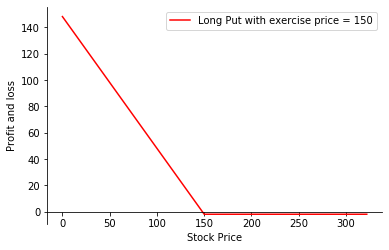

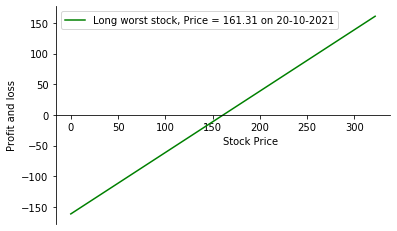

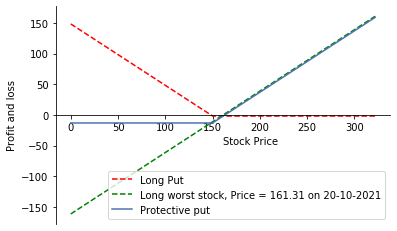

In [120]:
worst_sT = np.arange(0,2*worst_stock_price_20_10_21,1) 
profit_loss_long_put = put_profit_loss(worst_sT, 150, worst_put_premium)
# Plot long put 
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center
ax.plot(worst_sT,profit_loss_long_put,label='Long Put with exercise price = 150',color='r')
plt.xlabel('Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

# plot long worst stock 
profit_loss_long_stock = stock_profit_loss(worst_sT, worst_stock_price_20_10_21)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center
ax.plot(worst_sT,profit_loss_long_stock,label=f'Long worst stock, Price = {worst_stock_price_20_10_21} on 20-10-2021',color='g')
plt.xlabel('Stock Price', ha='left')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

# plot protective put (long put + long stock )
profit_loss_covered_call = profit_loss_long_put + profit_loss_long_stock
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed 
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center

ax.plot(worst_sT,profit_loss_long_put ,'--',label='Long Put',color='r')
ax.plot(worst_sT,profit_loss_long_stock,'--',label=f'Long worst stock, Price = {worst_stock_price_20_10_21} on 20-10-2021',color='g')

ax.plot(worst_sT,profit_loss_covered_call,label='Protective put')
plt.xlabel('Stock Price', ha='left')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

## Profit of Protective put 

In [121]:
worst_price_05_11_2021 = 136.75 # replace with 05-11-2021 closing price 
# Find out how many worst Stock we brought in 31-12-2020
worst_weight = 0.0166
# worst Price at 31-12-2020
worst_price_31_12_2020 = 214.68
# finding the number of stocks brought for worst on 31-12-2020
AUM = 5000000000
worst_weight_cash = worst_weight * AUM
worst_stock_brought = round(worst_weight_cash / worst_price_31_12_2020)
print(f"No. of worst Stocks brought on 31-12-2020: {worst_stock_brought}\n")

# total worst value on 20-10-2021
worst_portfolio_20_10_2021 = worst_stock_brought * worst_stock_price_20_10_21
print(f"worst stock price on 20-10-2021: {worst_stock_price_20_10_21}")
print(f"Total value of worst stock on 20-10-2021: {worst_portfolio_20_10_2021}\n")

# total worst value on 05-11-2021
worst_portfolio_05_11_2021 = worst_stock_brought * worst_price_05_11_2021
print(f"worst stock price on 05-11-2021: {worst_price_05_11_2021}")
print(f"Total value of worst stock on 05-11-2021: {worst_portfolio_05_11_2021}\n")

# Calculate profit for 1 worst put  
worst_option_profit_loss_long_put = put_profit_loss(worst_price_05_11_2021, 150, worst_put_premium)
print(f"Profit/loss of 1 worst long put with exercise price = 150 : {worst_option_profit_loss_long_put}")
total_worst_option_profit_loss_long_put = worst_option_profit_loss_long_put * worst_stock_brought
print(f"Total profit/loss of put option: {total_worst_option_profit_loss_long_put}\n")

# profit/loss of 1 worst stock 
worst_stock_profit_loss = worst_price_05_11_2021 - worst_stock_price_20_10_21
print(f"Profit/loss of 1 worst stock: ${worst_stock_profit_loss}, {worst_stock_profit_loss / worst_stock_price_20_10_21}%")

# profit/loss of 1 worst stock + 1 long put 
worst_stock_profit_loss_with_put = worst_stock_profit_loss + worst_option_profit_loss_long_put
print(f"Profit/loss of 1 worst stock with 1 put: ${worst_stock_profit_loss_with_put}, {worst_stock_profit_loss_with_put / worst_stock_price_20_10_21}%\n")

# total profit/loss without protective put 
worst_total_without_put = worst_portfolio_05_11_2021 - worst_portfolio_20_10_2021
print(f"Total worst profit/loss from 20-10-2021 to 05-11-2021 (Without protective put): {worst_total_without_put}")

# total profit/loss with protective put 
worst_total_with_put = worst_portfolio_05_11_2021 - worst_portfolio_20_10_2021 + total_worst_option_profit_loss_long_put
print(f"Total worst profit/loss from 20-10-2021 to 05-11-2021 (Without protective put): {worst_total_with_put}")

# differences 
print(f"Differences: {worst_total_with_put - worst_total_without_put}")

No. of worst Stocks brought on 31-12-2020: 386622

worst stock price on 20-10-2021: 161.31
Total value of worst stock on 20-10-2021: 62365994.82

worst stock price on 05-11-2021: 136.75
Total value of worst stock on 05-11-2021: 52870558.5

Profit/loss of 1 worst long put with exercise price = 150 : 11.4
Total profit/loss of put option: 4407490.8

Profit/loss of 1 worst stock: $-24.560000000000002, -0.15225342508214%
Profit/loss of 1 worst stock with 1 put: $-13.160000000000002, -0.08158204699026719%

Total worst profit/loss from 20-10-2021 to 05-11-2021 (Without protective put): -9495436.32
Total worst profit/loss from 20-10-2021 to 05-11-2021 (Without protective put): -5087945.5200000005
Differences: 4407490.8


# Most volatile stock 

## Finding the most volatile stock 

In [122]:
returns_df = get_data_for_multiple_stocks(tickers, start_date, end_date)
returns_df

,AAPL,AMZN,GOOG,PAYC,FB,MU,RNG,QCOM,HUBS,TSM,LRCX,MSFT,AMD,NXPI,GOOGL,PANW,FLEX,NVDA,GPN,TER,TSLA,SPLK,FISV,MNDT,VRNS,STM,SWKS,FIS,CYBR,VEEV
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-20,0.003356,-0.008482,-0.009831,-0.011752,0.002321,0.010306,-0.008865,-0.002569,0.005598,-0.011783,-0.009381,-0.002664,0.000516,0.002890,-0.010302,-0.001113,-0.013203,-0.008425,0.001986,0.001969,0.001769,0.010094,-0.010660,-0.001103,0.000158,-0.008142,0.005388,0.004584,-0.014614,0.002378
2021-10-21,0.001473,0.005825,0.002563,0.040710,0.003223,0.005405,0.027289,0.006712,0.008874,0.006038,-0.017986,0.010839,0.024946,0.018708,0.000825,-0.007687,0.007943,0.026299,-0.008217,0.005032,0.032052,0.009283,0.000454,-0.007200,0.014859,0.024687,0.007997,-0.001526,0.025164,0.016273
2021-10-22,-0.005299,-0.029382,-0.029536,0.003534,-0.051835,-0.016600,-0.000403,-0.010806,0.014450,-0.017873,0.002374,-0.005162,0.004098,-0.006581,-0.030916,-0.007647,-0.015413,0.001497,-0.012516,-0.012155,0.017387,-0.008088,0.000182,-0.007252,-0.018648,0.000456,-0.011142,0.004890,-0.000816,-0.014525
2021-10-25,-0.000336,-0.004561,0.001067,0.005787,0.012491,0.018346,-0.013598,0.002352,-0.010445,-0.005178,-0.008605,-0.003337,0.020977,0.001799,-0.000869,-0.012696,0.014358,0.019176,-0.001393,0.009940,0.119218,0.005300,0.008405,-0.003927,0.042731,0.013799,0.000363,-0.021013,-0.007210,0.003395
2021-10-26,0.004564,0.016636,0.006457,-0.003234,-0.039974,0.002614,-0.011923,0.000076,-0.000571,0.004741,-0.005504,0.006405,0.004648,-0.020887,0.013453,-0.022798,-0.011684,0.064806,-0.011538,-0.018329,-0.006294,-0.005838,-0.011496,-0.010738,-0.004557,0.005378,-0.005159,-0.000327,-0.018478,0.004157
2021-10-27,-0.003153,0.004852,0.047234,-0.010969,-0.011433,-0.010206,-0.019672,-0.005624,-0.010348,-0.003773,0.008489,0.041252,-0.005302,-0.019251,0.048404,0.012885,-0.023785,-0.010820,-0.078948,0.066518,0.018899,-0.024984,-0.105624,-0.018349,-0.019836,0.006237,0.009509,-0.069256,-0.013945,-0.029950
2021-10-28,0.024684,0.015815,-0.002041,0.011211,0.014941,0.019446,0.028197,0.018801,0.021598,0.019673,0.022027,0.003645,-0.009201,0.038189,-0.002523,0.011158,-0.064393,0.019842,-0.008991,0.107301,0.037056,0.007628,-0.003040,0.013222,0.006193,0.074441,0.023472,-0.020433,0.005815,0.002549
2021-10-29,-0.018322,-0.021746,0.014548,0.019408,0.020766,-0.006922,-0.000328,-0.004874,-0.005072,-0.020113,-0.004214,0.022167,-0.007705,0.004791,0.014951,0.021242,-0.014101,0.024789,0.001050,0.008937,0.033741,0.001943,-0.000406,-0.004006,-0.000772,-0.018097,-0.016085,-0.010421,0.013809,0.008713


In [123]:
# to be change on 5-11-2021
most_volatile_stock = returns_df.std().idxmax()
print(f"Most volatile stock from {start_date} to {end_date}: {most_volatile_stock}, std: {returns_df.std().max()}")

Most volatile stock from 2021-10-20 to 2021-11-05: TSLA, std: 0.0390019812596997
